# Analysis of the Combined data for 7pad Scanning

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch, Circle
from matplotlib.colors import LogNorm

import numpy as np
from scipy.optimize import minimize

from single_pad_analysis.analysis_functions import *
from single_pad_analysis.HexDetector import HexDetector, hex_radius_inner_to_outer

import matplotlib as mpl
mpl.rcdefaults()

In [2]:
run_number = 325
basedir_path = 'scan_pad_dfs/'
raw_file_dir = '/media/dn277127/EXTERNAL_USB/2312292/Extras/Physics/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/'
get_pad_csv_path = lambda pool_num, mm_channel: f'{basedir_path}Run{run_number}-Pool{pool_num}-{mm_channel}.csv'

pad_centers_df = pd.read_csv(f'{basedir_path}scan_pad_centers.csv')

In [3]:
class Pad:
    def __init__(self, pool_num, mm_channel, pad_index=0):
        self.pool_num = pool_num
        self.mm_channel = mm_channel
        self.pad_index = pad_index
        self.x_center = None
        self.y_center = None
        self.df = None

    def __repr__(self):
        return f"Pad(pool_num={self.pool_num}, mm_channel={self.mm_channel}, pad_index={self.pad_index}, x_center={self.x_center}, y_center={self.y_center})\n{self.df}"

In [4]:
pads = [  # Need to be careful about the pad index, has to match the HexDetector indexing!
    Pad(4, 'C4', 0),
    Pad(5, 'C2', 1),
    Pad(5, 'C4', 2),
    Pad(3, 'C2', 3),
    Pad(2, 'C4', 4),
    Pad(2, 'C2', 5),
    Pad(4, 'C2', 6)
]

# Need to be careful about the pad index, has to match the pads indexing!
detector = HexDetector(4.3, 29.9, 26.8, np.deg2rad(5.5))
detector.add_pad(0, -1, +1)
detector.add_pad(0, -1, 0)
detector.add_pad(0, -1, -1)
detector.add_pad(0, +1, -1)
detector.add_pad(0, +1, 0)
detector.add_pad(0, +1, +1)

In [5]:
# Update pads with pad center information
for pad in pads:
    pad_center_row = pad_centers_df[(pad_centers_df['run_number'] == run_number) & (pad_centers_df['pool_number'] == pad.pool_num) & (pad_centers_df['channel_number'] == pad.mm_channel)]
    if pad_center_row.empty:
        print(f"Pad center not found for run {run_number}, pool {pad.pool_num}, channel {pad.mm_channel}")
        continue
    elif len(pad_center_row) > 1:
        print(f"Multiple pad centers found for run {run_number}, pool {pad.pool_num}, channel {pad.mm_channel}")
        continue
    pad_center_row = pad_center_row.iloc[0]
    x_center = Measure(pad_center_row['x_center'], pad_center_row['x_center_err'])
    y_center = Measure(pad_center_row['y_center'], pad_center_row['y_center_err'])
    pad.x_center = x_center
    pad.y_center = y_center

In [6]:
# Load dataframes for each pad
for pad in pads:
    pad.df = pd.read_csv(get_pad_csv_path(pad.pool_num, pad.mm_channel))

In [7]:
# Get combined dataframe, concatenating on SRSNo
df_combined = None
for pad in pads:
    cols_rename = {x: f'{x}_{pad.pad_index}' for x in pad.df.columns if x != 'SRSNo'}
    if df_combined is None:
        df_combined = pad.df.rename(columns=cols_rename)
    else:
        df_combined = df_combined.merge(pad.df.rename(columns=cols_rename), on='SRSNo', how='outer')

# Get nan-ignored average of hitX and hitY and eventNo
df_combined['hitX'] = df_combined[[f'hitX_{pad.pad_index}' for pad in pads]].mean(axis=1)
df_combined['hitY'] = df_combined[[f'hitY_{pad.pad_index}' for pad in pads]].mean(axis=1)
df_combined['eventNo'] = df_combined[[f'eventNo_{pad.pad_index}' for pad in pads]].mean(axis=1).astype(int)


In [8]:
# Align hex detector to pad centers
def chi_square(params, pads, detector):
    x_center, y_center, angle = params
    detector.set_rotation(np.deg2rad(angle))
    detector.set_center(x_center, y_center)

    chi2_dx, chi2_dy = 0, 0
    for pad in pads:
        det_x, det_y = detector.get_pad_center(pad.pad_index)
        chi2_dx += ((pad.x_center.val - det_x) / pad.x_center.err)**2
        chi2_dy += ((pad.y_center.val - det_y) / pad.y_center.err)**2

    return np.sum(chi2_dx + chi2_dy)


def fit_hex_detector_to_pad_centers(pads, detector, x0=0, y0=0, angle0=0):
    initial_guess = [x0, y0, angle0]
    bounds = ((0, 100), (0, 100), (-20, 20))  # No bounds on x and y, angle between -180 and 180 degrees
    result = minimize(chi_square, initial_guess, args=(pads, detector), bounds=bounds)
    return result

# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads, detector, x0=29.9, y0=26.8, angle0=5.5)
print(fit_result)
print(fit_result.x)
detector.set_center(fit_result.x[0], fit_result.x[1])
detector.set_rotation(np.deg2rad(fit_result.x[2]))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 593.4774452257581
        x: [ 2.977e+01  2.661e+01  4.539e+00]
      nit: 10
      jac: [ 2.501e-04  1.330e-03  6.821e-04]
     nfev: 48
     njev: 12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[29.76822938 26.61414375  4.53920028]


In [9]:
if os.path.isdir(raw_file_dir):
    plot_single_event(df_combined, 1179, raw_file_dir, run_number, pads, detector)
else:
    print(f'{raw_file_dir} not found, skipping.')

/media/dn277127/EXTERNAL_USB/2312292/Extras/Physics/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ not found, skipping.


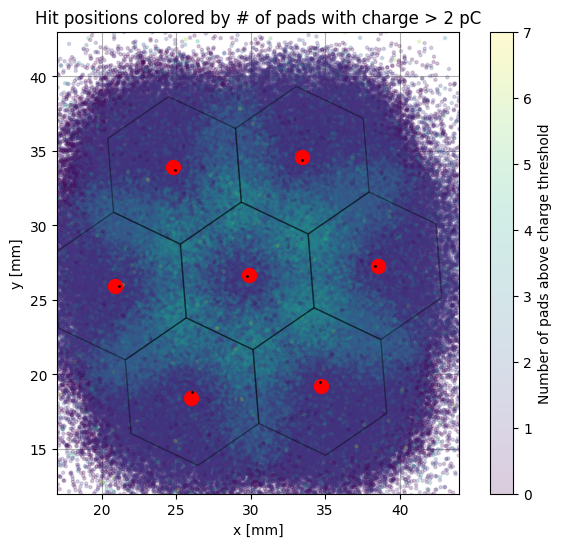

In [10]:
threshold = 2

# Replace NaNs with 0 (or any value below threshold)
totcharge_cols = [f'totcharge_{pad.pad_index}' for pad in pads]
charges = df_combined[totcharge_cols].fillna(0)

# Count how many values in each row are > threshold
charge_count = (charges > threshold).sum(axis=1)

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=charge_count, cmap='viridis', s=5, zorder=2, alpha=0.2)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(17, 44)
ax.set_ylim(12, 43)

for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')

ax.grid(True)
# ax.legend()
ax.set_aspect('equal')

detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.4, pad_colors='none')

In [11]:
# Rotate everything to square up detector
df_combined['hitX'], df_combined['hitY'] = rotate_points(df_combined['hitX'], df_combined['hitY'], -detector.rotation, detector.x, detector.y)
for pad_i in range(len(pads)):
    pads[pad_i].x_center, pads[pad_i].y_center = rotate_points(pads[pad_i].x_center, pads[pad_i].y_center, -detector.rotation, detector.x, detector.y)
detector.set_center(0, 0)
detector.set_rotation(np.deg2rad(0))

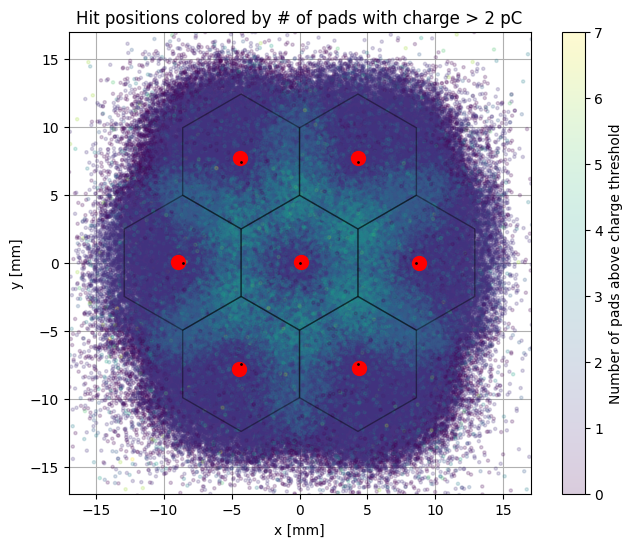

In [12]:
threshold = 2

# Replace NaNs with 0 (or any value below threshold)
totcharge_cols = [f'totcharge_{pad.pad_index}' for pad in pads]
charges = df_combined[totcharge_cols].fillna(0)

# Count how many values in each row are > threshold
charge_count = (charges > threshold).sum(axis=1)

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=charge_count, cmap='viridis', s=5, zorder=2, alpha=0.2)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)

for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')

ax.grid(True)
# ax.legend()
ax.set_aspect('equal')

detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.4, pad_colors='none')

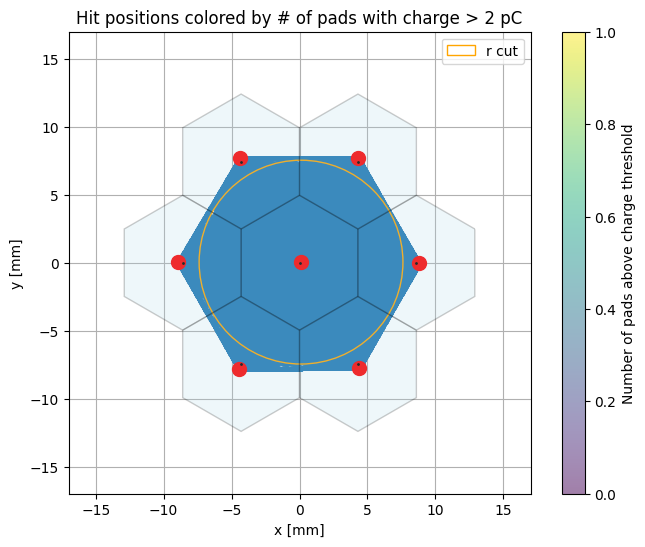

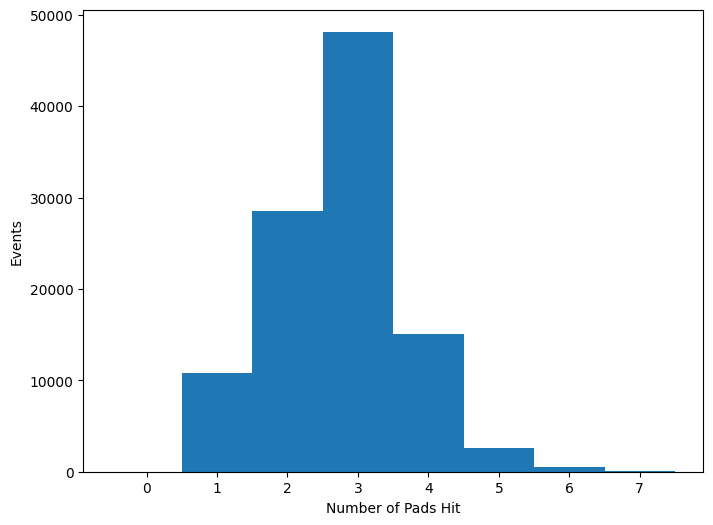

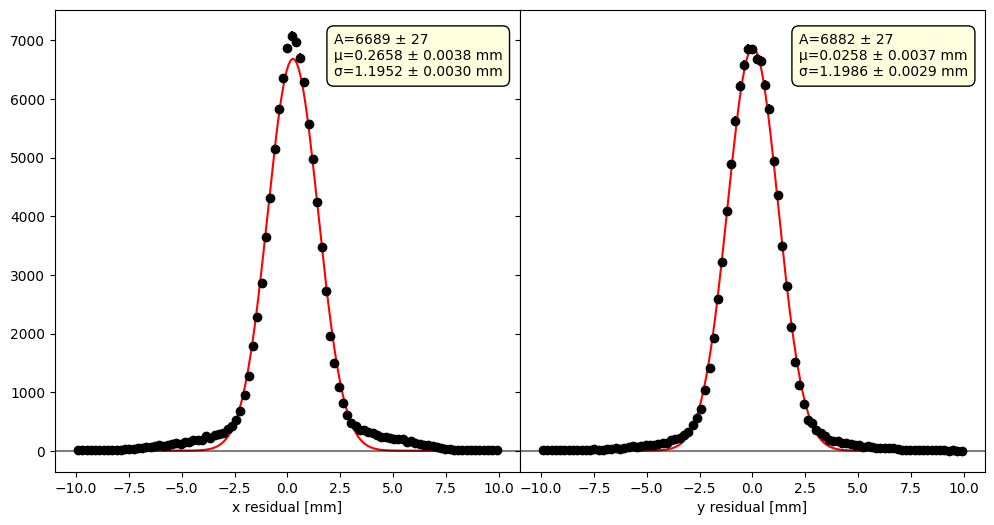

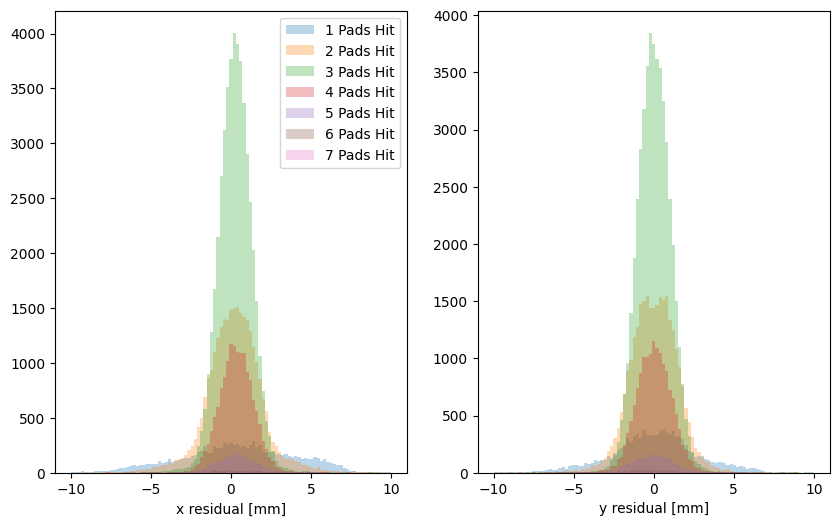

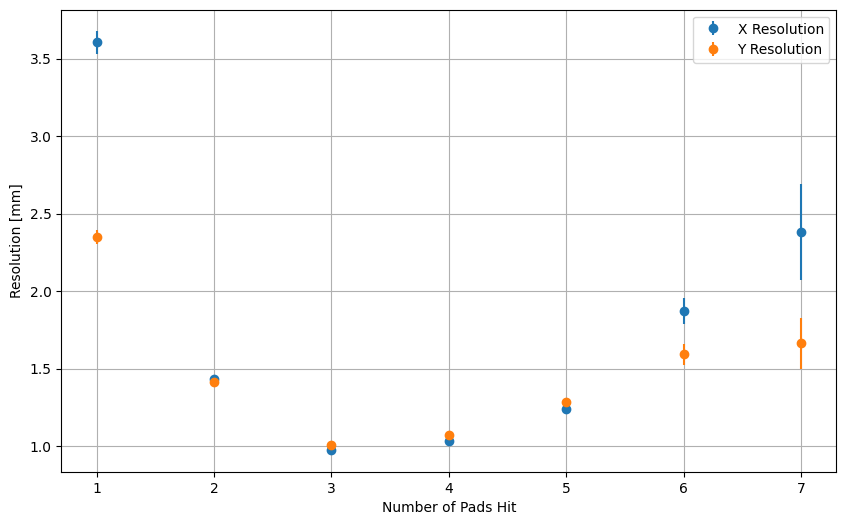

In [13]:
df_combined['r_center'] = np.sqrt((df_combined['hitX'] - detector.x)**2 + (df_combined['hitY'] - detector.y)**2)
r_center_cut = 7.5  # mm, should correspond to centers of surrounding pads
df_filter = df_combined[df_combined['r_center'] < r_center_cut]
x_tracks, y_tracks = df_filter['hitX'], df_filter['hitY']

# Assume pads is a list of Pad objects
weights, x_weighted, y_weighted, n_hits = [], [], [], []

for pad in pads:
    pad_idx = pad.pad_index
    weight = df_filter[f'totcharge_{pad_idx}'].fillna(0)
    weights.append(weight)
    n_hits.append(df_filter[f'totcharge_{pad_idx}'].notna().astype(int))
    x_weighted.append(pad.x_center.val * weight)
    y_weighted.append(pad.y_center.val * weight)

weight_sum = sum(weights)
n_hits = sum(n_hits)
x_hits = sum(x_weighted) / weight_sum
y_hits = sum(y_weighted) / weight_sum

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x_hits, y_hits, cmap='viridis', s=5, zorder=2, alpha=0.5)
circle = Circle((pads[0].x_center.val, pads[0].y_center.val), r_center_cut, color='orange', fill=False, zorder=3, label='r cut')
ax.add_patch(circle)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3)
ax.grid(True)
# ax.legend()
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)
ax.legend()

# Plot n_hits histogram
fig_nhits, ax_nhits = plt.subplots(figsize=(8, 6))
ax_nhits.hist(n_hits, bins=np.arange(0 - 0.5, np.max(n_hits) + 2 - 0.5, 1))
ax_nhits.set_xlabel('Number of Pads Hit')
ax_nhits.set_ylabel('Events')

# Get residuals
x_resids = np.array(x_hits) - np.array(x_tracks)
y_resids = np.array(y_hits) - np.array(y_tracks)

binning = np.linspace(-10, 10, 100)
bin_centers = (binning[1:] + binning[:-1]) / 2

x_resid_hist, x_resid_bin_edges = np.histogram(x_resids, bins=binning)
x_resid_err = np.where(x_resid_hist > 0, np.sqrt(x_resid_hist), 1)
y_resid_hist, y_resid_bin_edges = np.histogram(y_resids, bins=binning)
y_resid_err = np.where(y_resid_hist > 0, np.sqrt(y_resid_hist), 1)

x_resid_popt, x_resid_pcov = cf(gaus, bin_centers, x_resid_hist, p0=[np.max(x_resid_hist), np.mean(x_resids), np.std(x_resids)], sigma=x_resid_err, absolute_sigma=True)
x_resid_meases = [Measure(val, err) for val, err in zip(x_resid_popt, np.sqrt(np.diag(x_resid_pcov)))]
y_resid_popt, y_resid_pcov = cf(gaus, bin_centers, y_resid_hist, p0=[np.max(y_resid_hist), np.mean(y_resids), np.std(y_resids)], sigma=y_resid_err, absolute_sigma=True)
y_resid_meases = [Measure(val, err) for val, err in zip(y_resid_popt, np.sqrt(np.diag(y_resid_pcov)))]

x_plt = np.linspace(binning[0], binning[-1], 200)

fig_resids, ax_resids = plt.subplots(ncols=2, figsize=(12, 6), sharey='all', sharex='all')
ax_resids[0].errorbar(bin_centers, x_resid_hist, yerr=x_resid_err, color='black', fmt='o', ls='none')
ax_resids[1].errorbar(bin_centers, y_resid_hist, yerr=y_resid_err, color='black', fmt='o', ls='none')
ax_resids[0].plot(x_plt, gaus(x_plt, *x_resid_popt), color='red')
ax_resids[1].plot(x_plt, gaus(x_plt, *y_resid_popt), color='red')
ax_resids[0].axhline(0, color='black', alpha=0.5)
ax_resids[1].axhline(0, color='black', alpha=0.5)
ax_resids[0].set_xlabel('x residual [mm]')
ax_resids[1].set_xlabel('y residual [mm]')
x_fit_str = f'A={x_resid_meases[0]}\nμ={x_resid_meases[1]} mm\nσ={x_resid_meases[2]} mm'
ax_resids[0].annotate(x_fit_str, xy=(0.6, 0.95), xycoords='axes fraction', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow'))
y_fit_str = f'A={y_resid_meases[0]}\nμ={y_resid_meases[1]} mm\nσ={y_resid_meases[2]} mm'
ax_resids[1].annotate(y_fit_str, xy=(0.6, 0.95), xycoords='axes fraction', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow'))
fig_resids.subplots_adjust(wspace=0)

fig_resids_nhits, ax_resids_nhits = plt.subplots(ncols=2, figsize=(10, 6))
n_hits_plt, res_x_plt, res_y_plt = [], [], []
for n_hit_i in range(1, max(n_hits) + 1):
    x_hist_i, _, _ = ax_resids_nhits[0].hist(x_resids[n_hits == n_hit_i], bins=binning, label=f'{n_hit_i} Pads Hit', alpha=0.3)
    y_hist_i, _, _ = ax_resids_nhits[1].hist(y_resids[n_hits == n_hit_i], bins=binning, label=f'{n_hit_i} Pads Hit', alpha=0.3)
    popt_x, pcov_x = cf(gaus, bin_centers, x_hist_i, p0=[np.max(x_hist_i), np.mean(x_resids[n_hits == n_hit_i]), np.std(x_resids[n_hits == n_hit_i])])
    pmeas_x = [Measure(val, err) for val, err in zip(popt_x, np.sqrt(np.diag(pcov_x)))]
    popt_y, pcov_y = cf(gaus, bin_centers, y_hist_i, p0=[np.max(y_hist_i), np.mean(y_resids[n_hits == n_hit_i]), np.std(y_resids[n_hits == n_hit_i])])
    pmeas_y = [Measure(val, err) for val, err in zip(popt_y, np.sqrt(np.diag(pcov_y)))]
    n_hits_plt.append(n_hit_i)
    res_x_plt.append(abs(pmeas_x[2]))
    res_y_plt.append(abs(pmeas_y[2]))

ax_resids_nhits[0].legend()
ax_resids_nhits[0].set_xlabel('x residual [mm]')
ax_resids_nhits[1].set_xlabel('y residual [mm]')

fig_resolutions, ax_resolutions = plt.subplots(figsize=(10, 6))
ax_resolutions.errorbar(n_hits_plt, [x.val for x in res_x_plt], yerr=[x.err for x in res_x_plt], label='X Resolution', ls='none', marker='o')
ax_resolutions.errorbar(n_hits_plt, [y.val for y in res_y_plt], yerr=[y.err for y in res_y_plt], label='Y Resolution', ls='none', marker='o')
ax_resolutions.legend()
ax_resolutions.set_ylabel('Resolution [mm]')
ax_resolutions.set_xlabel('Number of Pads Hit')
ax_resolutions.grid(zorder=0)

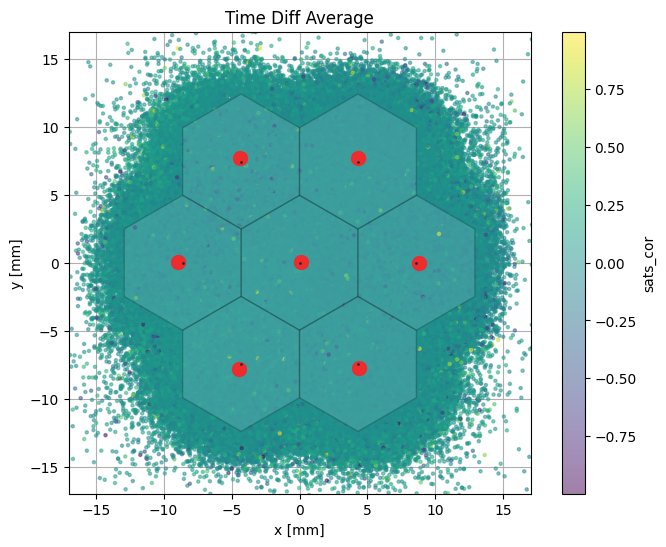

In [14]:
weights, charge_weights, charges, time_diffs_weighted, time_diff_cors_weighted, time_diff_cors_charge_weighted, time_diffs_max, time_diff_cors_max = [], [], [], [], [], [], [], []
for pad in pads:
    pad_idx = pad.pad_index
    weight = (df_combined[f'charge_time_res_{pad_idx}'] ** -2).fillna(0)
    charge_weight = df_combined[f'totcharge_{pad_idx}'].fillna(0)

    weight = np.where(df_combined[f'totcharge_{pad_idx}'] > threshold, weight, 0)
    charge_weight = np.where(df_combined[f'totcharge_{pad_idx}'] > threshold, charge_weight, 0)

    if f'time_diff_range_cut_{pad_idx}' in df_combined.columns:
        weight = np.where(df_combined[f'time_diff_range_cut_{pad_idx}'], weight, 0)
        charge_weight = np.where(df_combined[f'time_diff_range_cut_{pad_idx}'], charge_weight, 0)

    charges = df_combined[f'totcharge_{pad_idx}'].fillna(0)

    time_diff = df_combined[f'time_diff_{pad_idx}'].fillna(0)
    time_diff_cor = df_combined[f'time_diff_cor_{pad_idx}'].fillna(0)
    weights.append(weight)
    charge_weights.append(charge_weight)
    time_diffs_weighted.append(time_diff * weight)
    time_diff_cors_weighted.append(time_diff_cor * weight)
    time_diff_cors_charge_weighted.append(time_diff_cor * charge_weight)
    time_diffs_max.append(time_diff)
    time_diff_cors_max.append(time_diff_cor)

# Calculate the weighted average of time_diff and time_diff_cor
weight_sum = sum(weights)
charge_weight_sum = sum(charge_weights)
time_diff_weighted = sum(time_diffs_weighted) / weight_sum
time_diff_cor_weighted = sum(time_diff_cors_weighted) / weight_sum
time_diff_cor_charge_weighted = sum(time_diff_cors_charge_weighted) / charge_weight_sum

# Build arrays for charges and time_diff_cors
charge_array = np.stack([
    df_combined[f'totcharge_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)  # shape: (n_events, n_pads)

time_diff_array = np.stack([
    df_combined[f'time_diff_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)

time_diff_cor_array = np.stack([
    df_combined[f'time_diff_cor_{pad.pad_index}'].fillna(0).to_numpy()
    for pad in pads
], axis=1)  # shape: (n_events, n_pads)

# For each row (event), get the index of the pad with max charge
max_charge_indices = np.argmax(charge_array, axis=1)  # shape: (n_events,)

# Use advanced indexing to select the time_diff_cor at that index
time_diffs_max = time_diff_array[np.arange(charge_array.shape[0]), max_charge_indices]
time_diff_cors_max = time_diff_cor_array[np.arange(charge_array.shape[0]), max_charge_indices]

time_diff_cor_weighted = np.where((time_diff_cor_weighted < -1) | (time_diff_cor_weighted > 1), np.nan, time_diff_cor_weighted)
time_diff_cor_charge_weighted = np.where((time_diff_cor_charge_weighted < -1) | (time_diff_cor_charge_weighted > 1), np.nan, time_diff_cor_charge_weighted)

# Plot 2D scatter plot of histX_0 and histY_0 with color determined by sats_cor
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=time_diff_cor_weighted, cmap='viridis', s=5, zorder=2, alpha=0.5)
fig.colorbar(scatter, label='sats_cor')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Time Diff Average')
ax.set_xlim(detector.x - 17, detector.x + 17)
ax.set_ylim(detector.y - 17, detector.y + 17)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3)
ax.grid(True)
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)

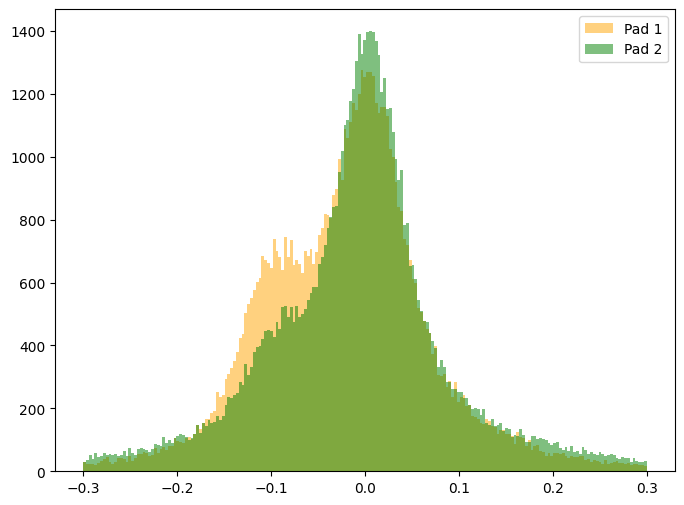

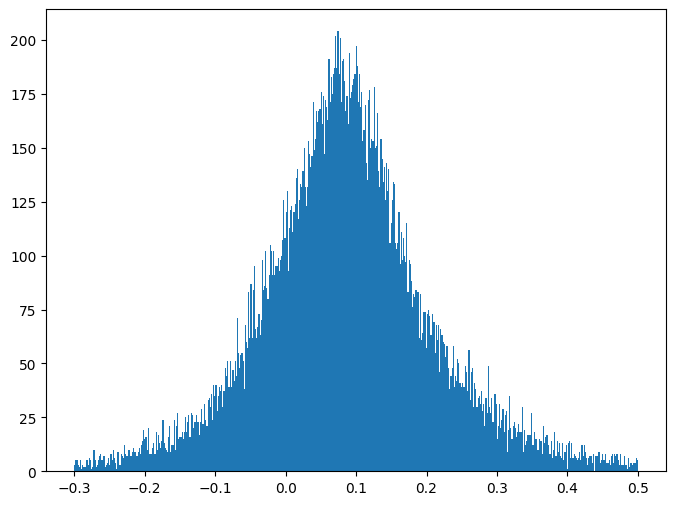

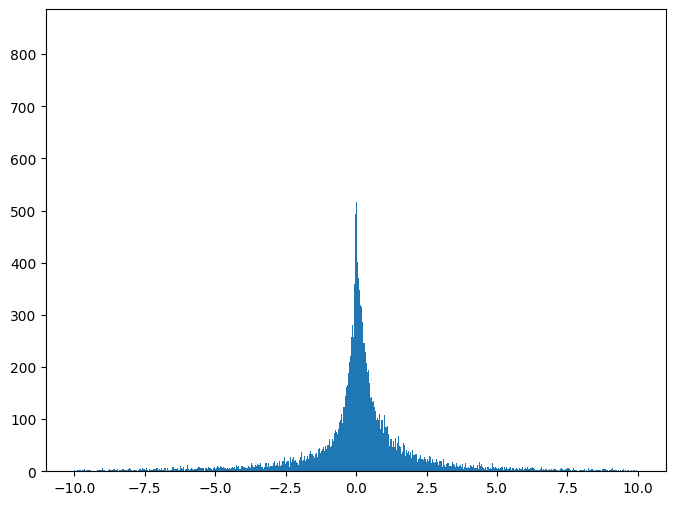

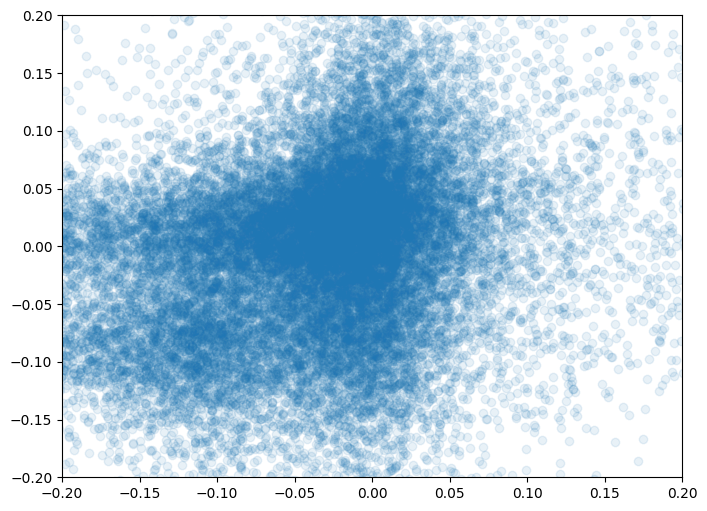

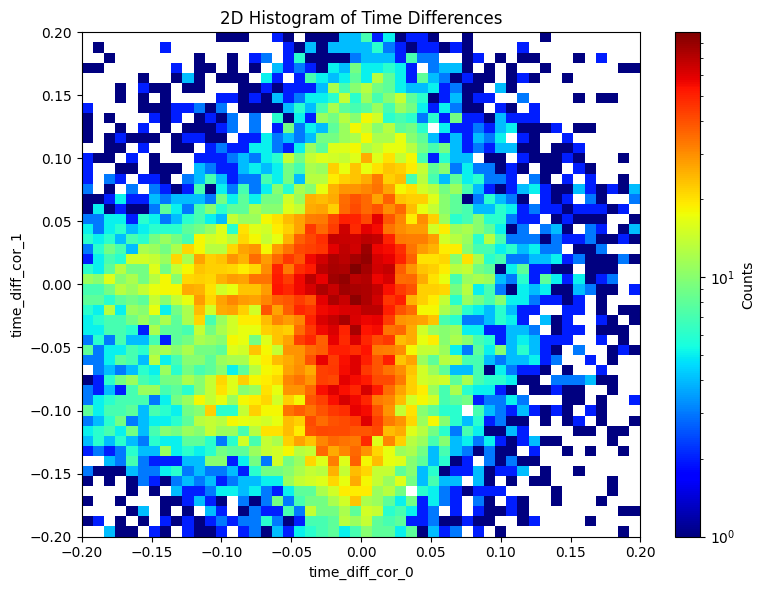

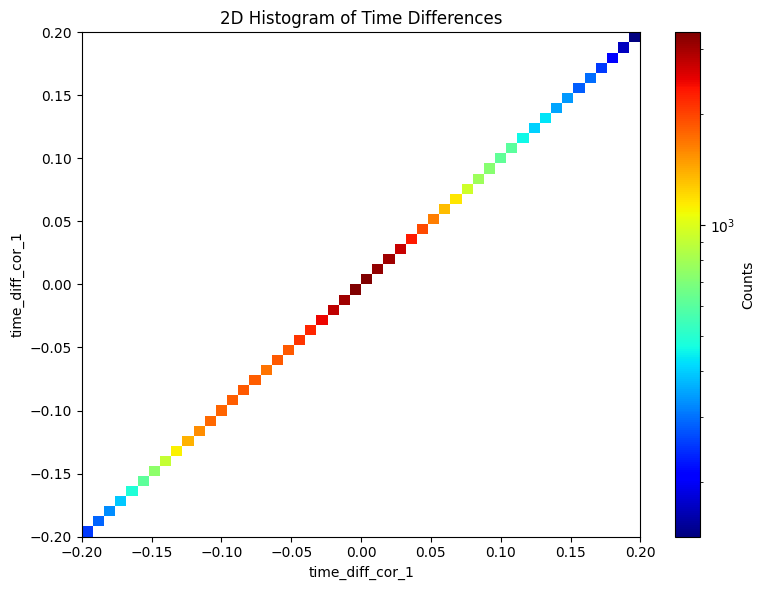

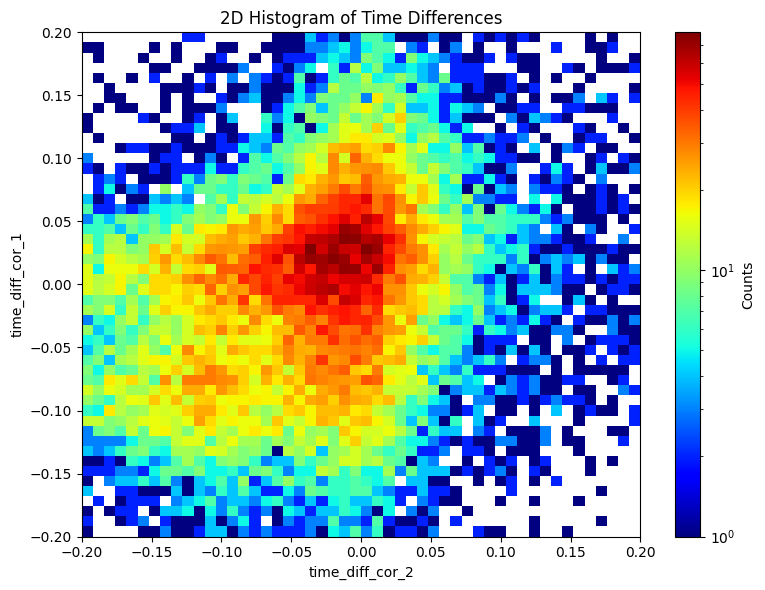

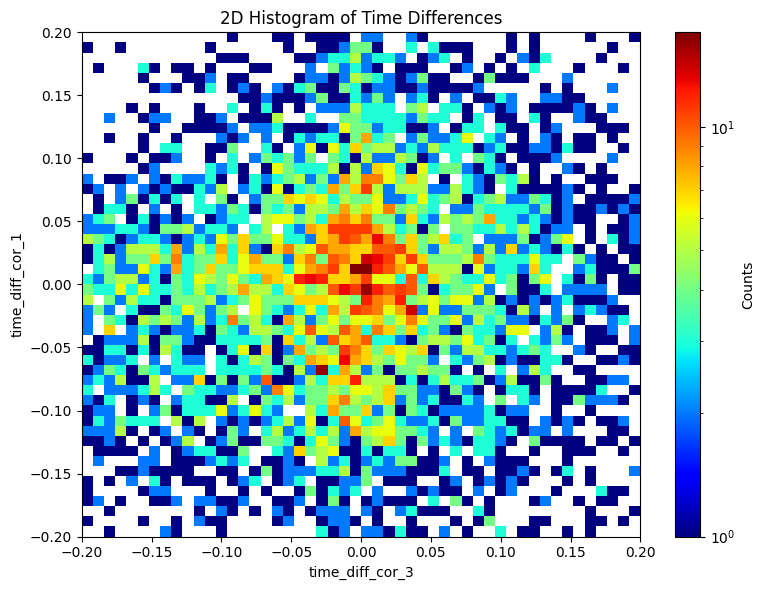

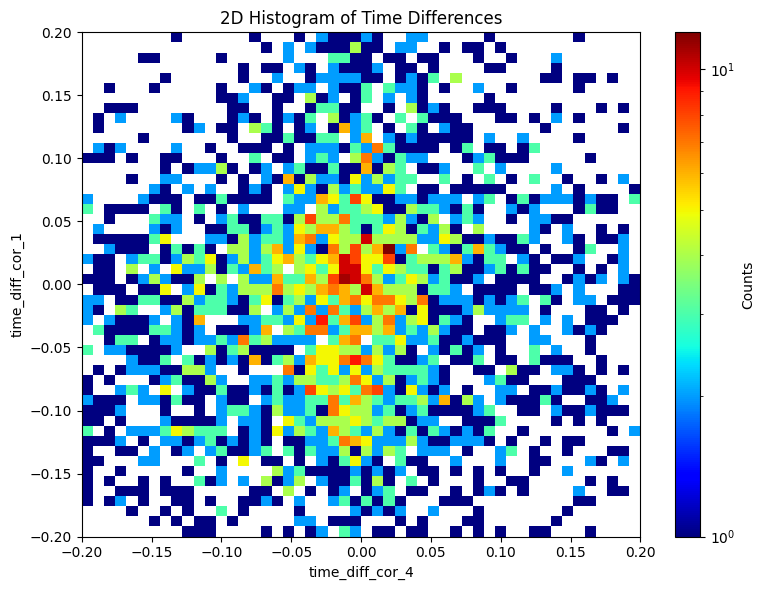

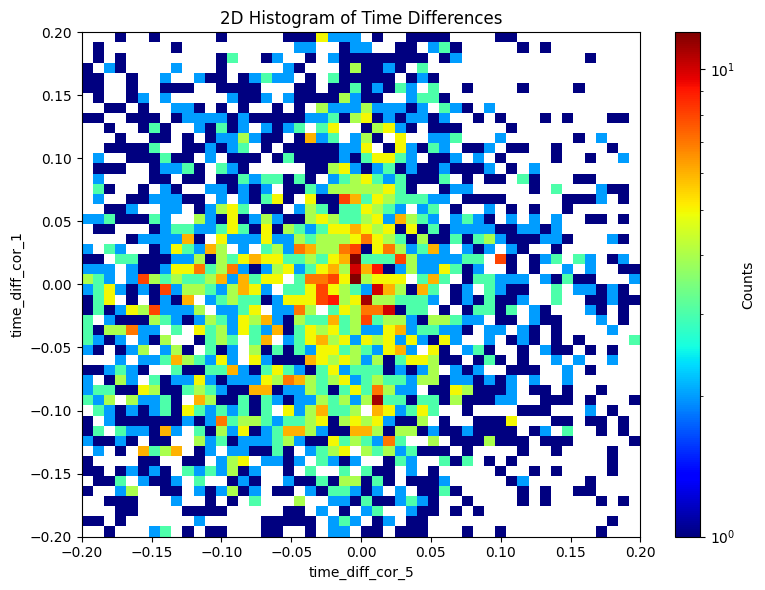

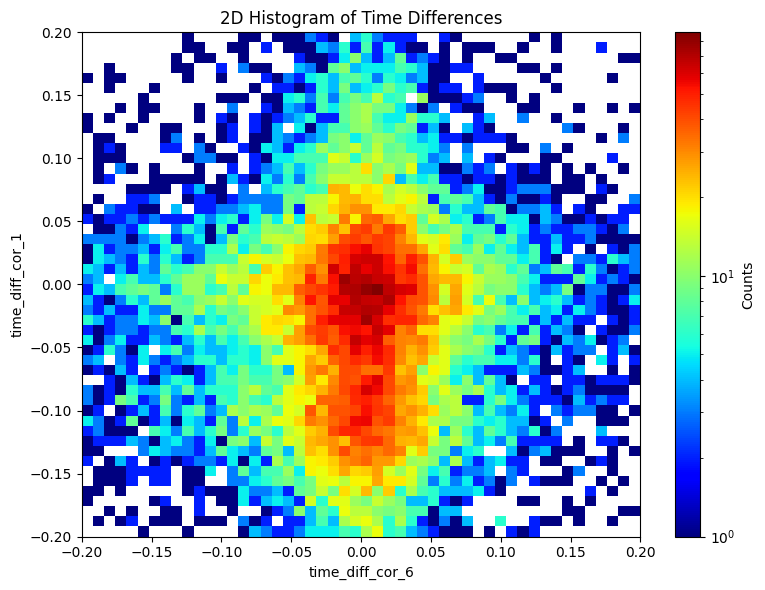

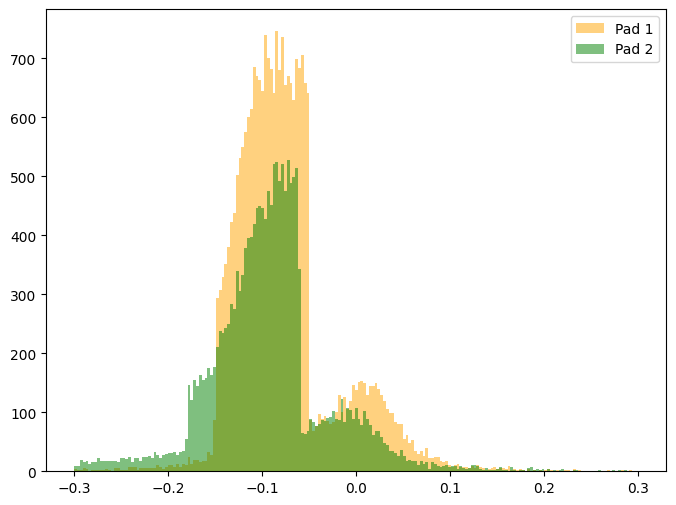

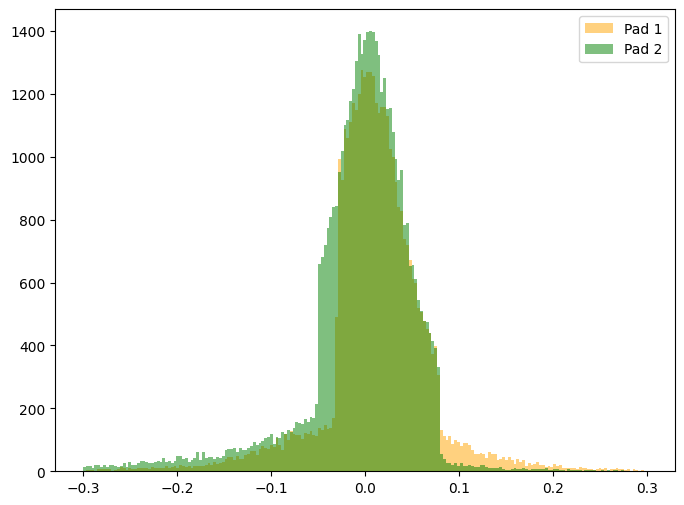

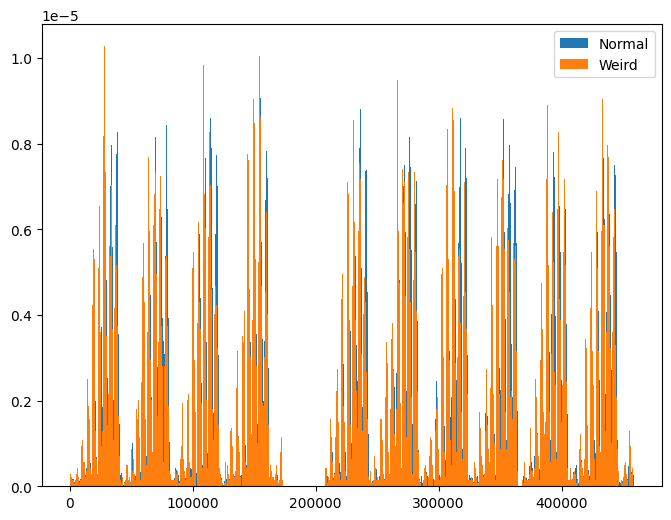

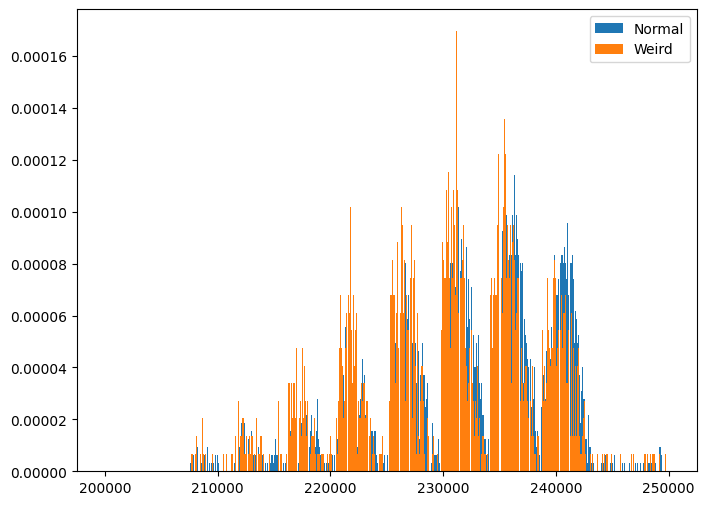

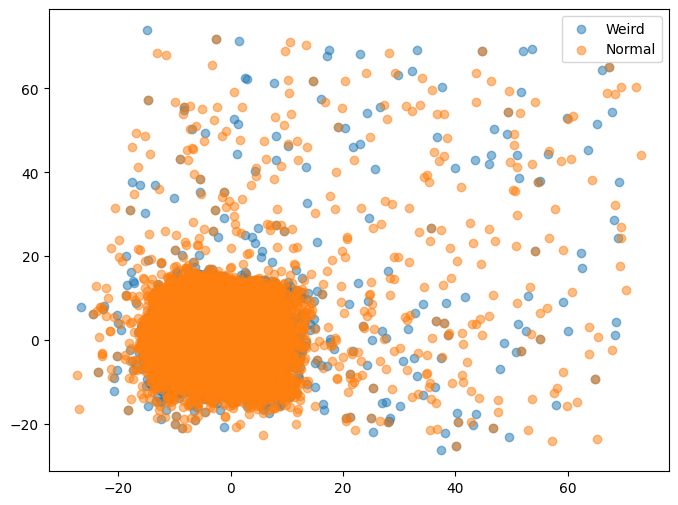

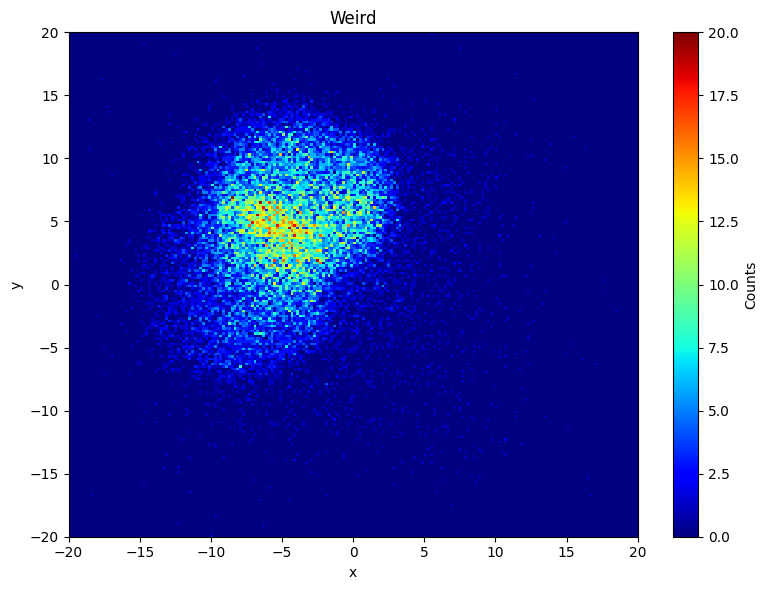

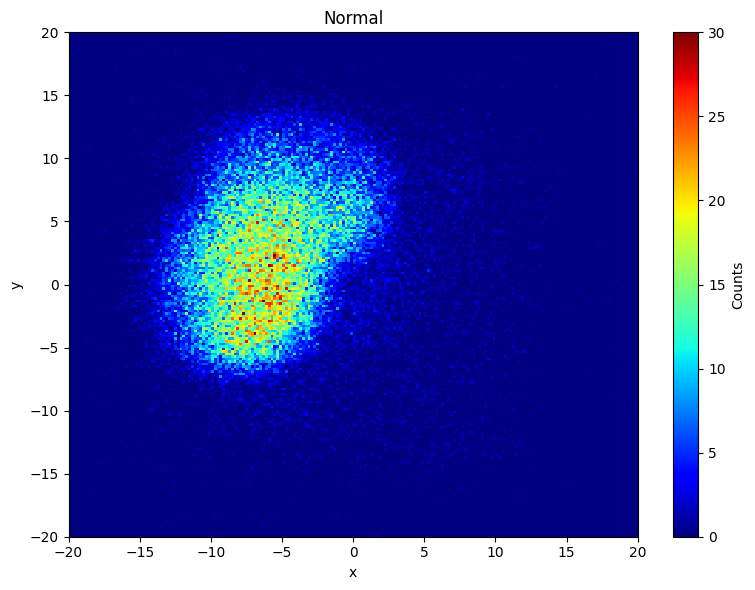

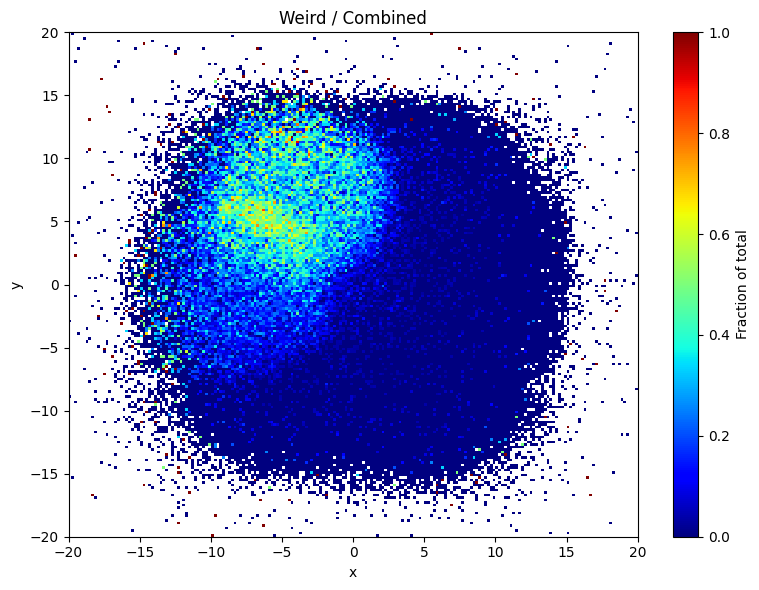

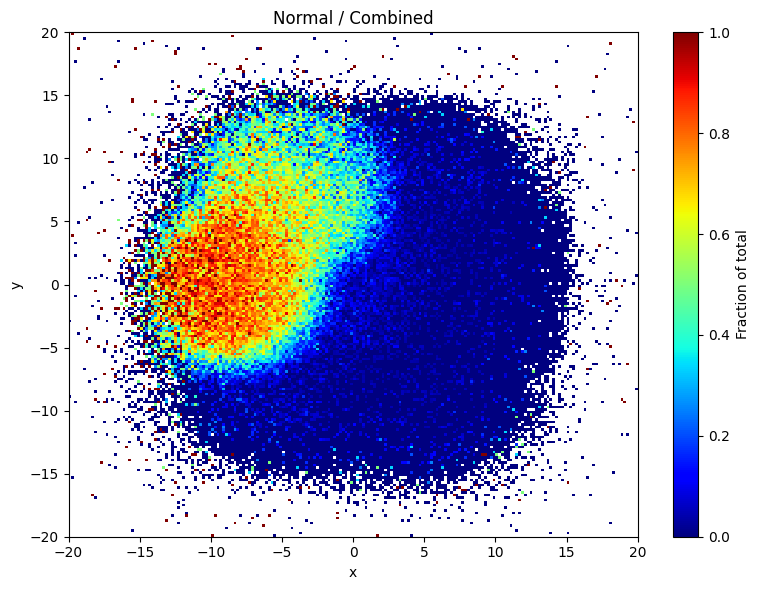

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
binning = np.linspace(-0.3, 0.3, 200)
# ax.hist(df_combined[f'time_diff_cor_6'], bins=binning, label='Pad 6', color='blue', alpha=0.5)
ax.hist(df_combined[f'time_diff_cor_1'], bins=binning, label='Pad 1', color='orange', alpha=0.5)
# ax.hist(df_combined[f'time_diff_cor_0'], bins=binning, label='Pad 0', color='green', alpha=0.5)
ax.hist(df_combined[f'time_diff_cor_2'], bins=binning, label='Pad 2', color='green', alpha=0.5)
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
binning = np.linspace(-0.3, 0.5, 500)
ax.hist(df_combined[f'time_diff_1'] - df_combined[f'time_diff_2'], bins=binning)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_combined[f'time_diff_cor_0'] / df_combined[f'time_diff_cor_1'], bins=np.linspace(-10, 10, 1000))

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_combined[f'time_diff_cor_2'], df_combined[f'time_diff_cor_1'], alpha=0.1)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)

for i in range(7):
    # Make 2D histogram
    fig, ax = plt.subplots(figsize=(8, 6))

    # 2D histogram
    h = ax.hist2d(
        df_combined[f'time_diff_cor_{i}'],
        df_combined['time_diff_cor_1'],
        bins=50,
        range=[[-0.2, 0.2], [-0.2, 0.2]],
        cmap='jet',
        norm=LogNorm()
    )

    # Add colorbar
    fig.colorbar(h[3], ax=ax, label='Counts')

    # Axis limits
    # ax.set_xlim(-1, 1)
    # ax.set_ylim(-1, 1)

    ax.set_xlabel(f'time_diff_cor_{i}')
    ax.set_ylabel('time_diff_cor_1')
    ax.set_title('2D Histogram of Time Differences')
    plt.tight_layout()

# Select where pad 1 and pad 2 in range
df_weird = df_combined[((df_combined['time_diff_cor_1'] < -0.05) & (df_combined['time_diff_cor_1'] > -0.15)) | ((df_combined['time_diff_cor_2'] < -0.06) & (df_combined['time_diff_cor_2'] > -0.18))]

fig, ax = plt.subplots(figsize=(8, 6))
binning = np.linspace(-0.3, 0.3, 200)
# ax.hist(df_combined[f'time_diff_cor_6'], bins=binning, label='Pad 6', color='blue', alpha=0.5)
ax.hist(df_weird[f'time_diff_cor_1'], bins=binning, label='Pad 1', color='orange', alpha=0.5)
# ax.hist(df_combined[f'time_diff_cor_0'], bins=binning, label='Pad 0', color='green', alpha=0.5)
ax.hist(df_weird[f'time_diff_cor_2'], bins=binning, label='Pad 2', color='green', alpha=0.5)
ax.legend()

# Select where pad 1 and pad 2 in range
df_norm = df_combined[((df_combined['time_diff_cor_1'] > -0.03) & (df_combined['time_diff_cor_1'] < 0.08)) | ((df_combined['time_diff_cor_2'] > -0.05) & (df_combined['time_diff_cor_2'] < 0.08))]

fig, ax = plt.subplots(figsize=(8, 6))
binning = np.linspace(-0.3, 0.3, 200)
# ax.hist(df_combined[f'time_diff_cor_6'], bins=binning, label='Pad 6', color='blue', alpha=0.5)
ax.hist(df_norm[f'time_diff_cor_1'], bins=binning, label='Pad 1', color='orange', alpha=0.5)
# ax.hist(df_combined[f'time_diff_cor_0'], bins=binning, label='Pad 0', color='green', alpha=0.5)
ax.hist(df_norm[f'time_diff_cor_2'], bins=binning, label='Pad 2', color='green', alpha=0.5)
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_norm['SRSNo'], bins=1000, density=True, label='Normal')
ax.hist(df_weird['SRSNo'], bins=1000, density=True, label='Weird')
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
binning = np.linspace(200000, 250000, 1000)
ax.hist(df_norm['SRSNo'], bins=binning, density=True, label='Normal')
ax.hist(df_weird['SRSNo'], bins=binning, density=True, label='Weird')
ax.legend()

fix, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_weird['hitX'], df_weird['hitY'], label='Weird', alpha=0.5)
ax.scatter(df_norm['hitX'], df_norm['hitY'], label='Normal', alpha=0.5)
ax.legend()


fig, ax = plt.subplots(figsize=(8, 6))
# 2D histogram
h = ax.hist2d(
    df_weird['hitX'], df_weird['hitY'],
    bins=200,
    range=[[-20, 20], [-20, 20]],
    cmap='jet',
    # norm=LogNorm()
)

# Add colorbar
fig.colorbar(h[3], ax=ax, label='Counts')

ax.set_xlabel(f'x')
ax.set_ylabel('y')
ax.set_title('Weird')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(8, 6))
# 2D histogram
h = ax.hist2d(
    df_norm['hitX'], df_norm['hitY'],
    bins=200,
    range=[[-20, 20], [-20, 20]],
    cmap='jet',
    # norm=LogNorm()
)

# Add colorbar
fig.colorbar(h[3], ax=ax, label='Counts')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Normal')
plt.tight_layout()

# First, compute histograms without plotting
bins = 200
range_ = [[-20, 20], [-20, 20]]

# Histogram for combined data
hist_combined, xedges, yedges = np.histogram2d(
    df_combined['hitX'], df_combined['hitY'],
    bins=bins, range=range_
)

# Histogram for weird subset
hist_weird, _, _ = np.histogram2d(
    df_weird['hitX'], df_weird['hitY'],
    bins=bins, range=range_
)

# Histogram for normal subset
hist_norm, _, _ = np.histogram2d(
    df_norm['hitX'], df_norm['hitY'],
    bins=bins, range=range_
)

# Now divide safely
with np.errstate(divide='ignore', invalid='ignore'):
    weird_fraction = np.divide(hist_weird, hist_combined, where=hist_combined > 0)
    norm_fraction = np.divide(hist_norm, hist_combined, where=hist_combined > 0)

# Mask invalid (where hist_combined == 0)
weird_fraction = np.ma.masked_where(hist_combined == 0, weird_fraction)
norm_fraction = np.ma.masked_where(hist_combined == 0, norm_fraction)

# Now plot weird_fraction
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(xedges, yedges, weird_fraction.T, cmap='jet', vmin=0, vmax=1)
fig.colorbar(pcm, ax=ax, label='Fraction of total')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Weird / Combined')
plt.tight_layout()

# Now plot norm_fraction
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(xedges, yedges, norm_fraction.T, cmap='jet', vmin=0, vmax=1)
fig.colorbar(pcm, ax=ax, label='Fraction of total')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Normal / Combined')
plt.tight_layout()

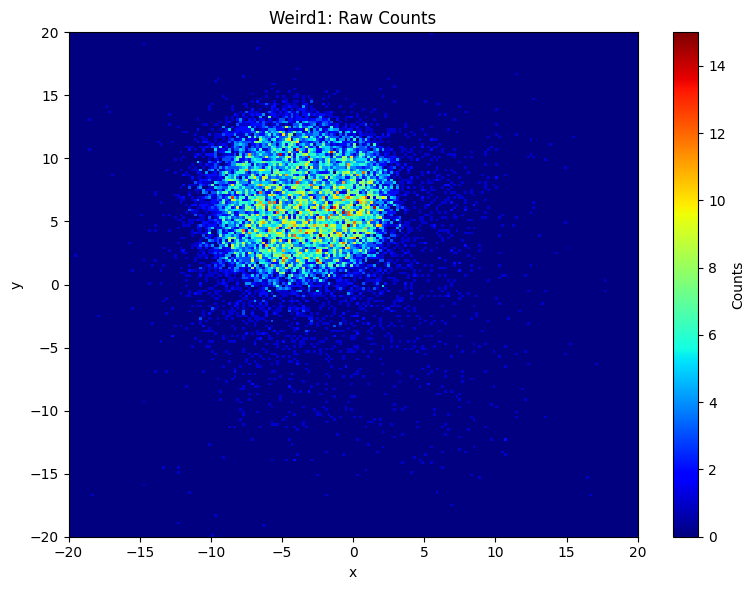

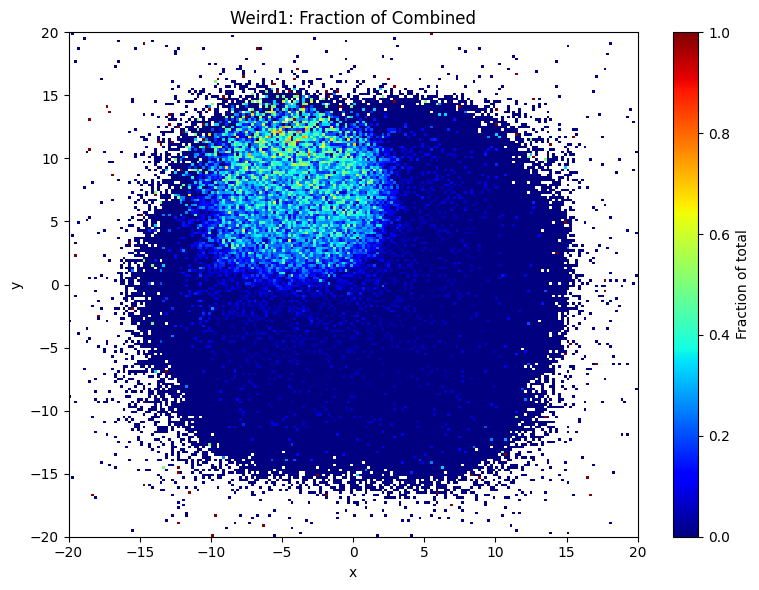

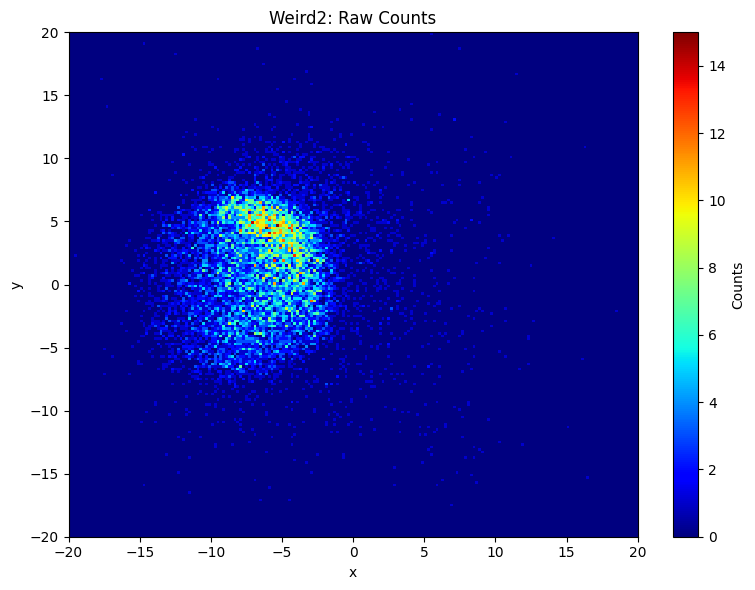

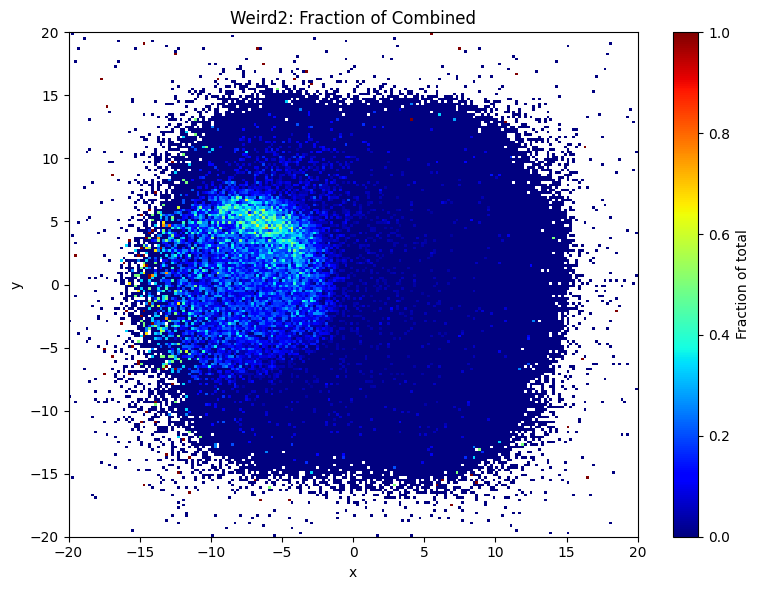

In [20]:
df_weird1 = df_combined[((df_combined['time_diff_cor_1'] < -0.05) & (df_combined['time_diff_cor_1'] > -0.15))]

df_weird2 = df_combined[((df_combined['time_diff_cor_2'] < -0.06) & (df_combined['time_diff_cor_2'] > -0.18))]

# Define general settings
bins = 200
range_ = [[-20, 20], [-20, 20]]

# Histograms for combined
hist_combined, xedges, yedges = np.histogram2d(
    df_combined['hitX'], df_combined['hitY'],
    bins=bins, range=range_
)

# Histograms for weird1
hist_weird1, _, _ = np.histogram2d(
    df_weird1['hitX'], df_weird1['hitY'],
    bins=bins, range=range_
)

# Histograms for weird2
hist_weird2, _, _ = np.histogram2d(
    df_weird2['hitX'], df_weird2['hitY'],
    bins=bins, range=range_
)

# Calculate normalized fractions
with np.errstate(divide='ignore', invalid='ignore'):
    weird1_fraction = np.divide(hist_weird1, hist_combined, where=hist_combined > 0)
    weird2_fraction = np.divide(hist_weird2, hist_combined, where=hist_combined > 0)

# Mask zeros
weird1_fraction = np.ma.masked_where(hist_combined == 0, weird1_fraction)
weird2_fraction = np.ma.masked_where(hist_combined == 0, weird2_fraction)

# ------------------------
# Plot df_weird1 counts
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(xedges, yedges, hist_weird1.T, cmap='jet')
fig.colorbar(pcm, ax=ax, label='Counts')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Weird1: Raw Counts')
plt.tight_layout()

# Plot df_weird1 normalized
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(xedges, yedges, weird1_fraction.T, cmap='jet', vmin=0, vmax=1)
fig.colorbar(pcm, ax=ax, label='Fraction of total')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Weird1: Fraction of Combined')
plt.tight_layout()

# ------------------------
# Plot df_weird2 counts
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(xedges, yedges, hist_weird2.T, cmap='jet')
fig.colorbar(pcm, ax=ax, label='Counts')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Weird2: Raw Counts')
plt.tight_layout()

# Plot df_weird2 normalized
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(xedges, yedges, weird2_fraction.T, cmap='jet', vmin=0, vmax=1)
fig.colorbar(pcm, ax=ax, label='Fraction of total')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Weird2: Fraction of Combined')
plt.tight_layout()

/tmp/ipykernel_11463/3512750624.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 6))


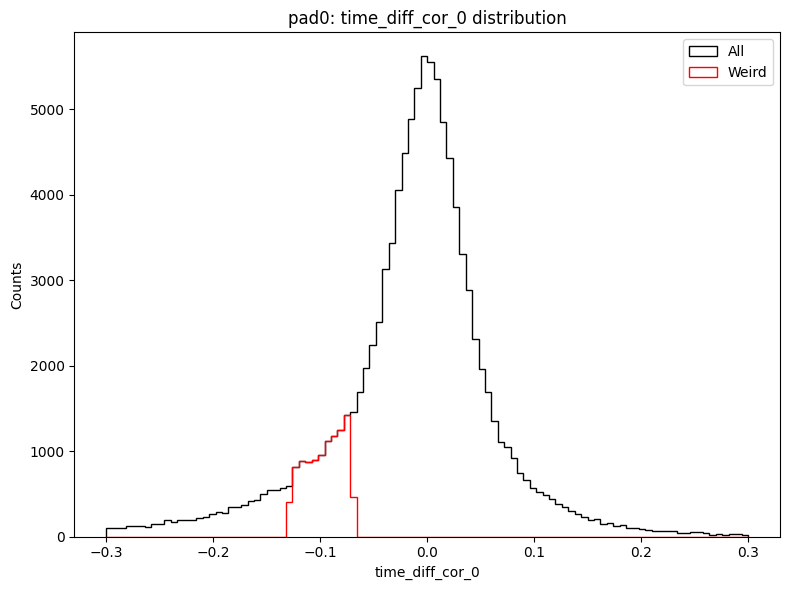

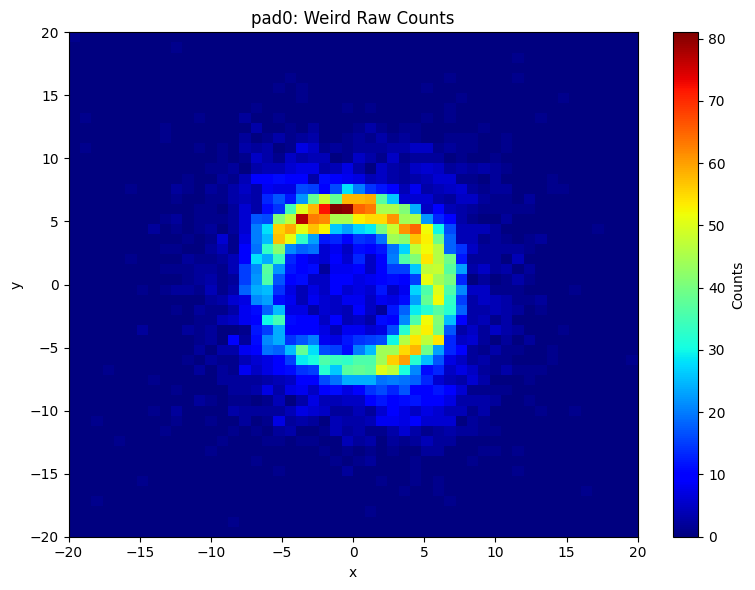

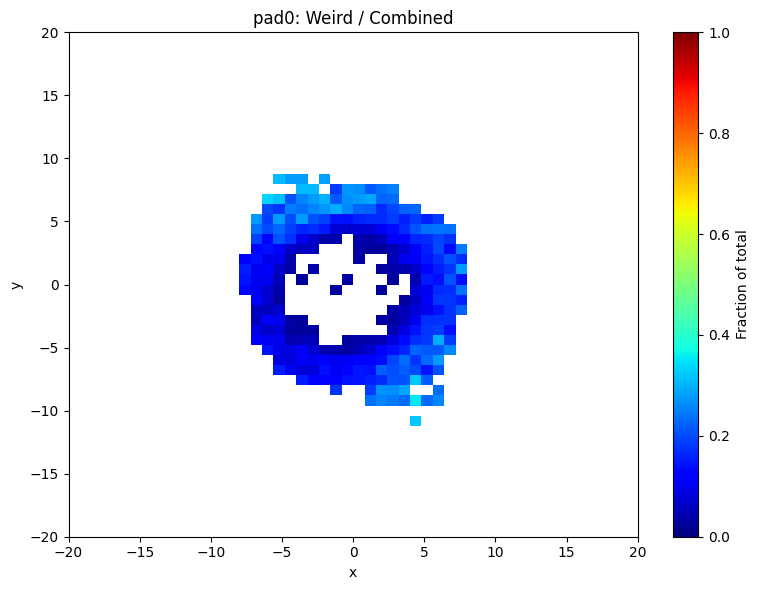

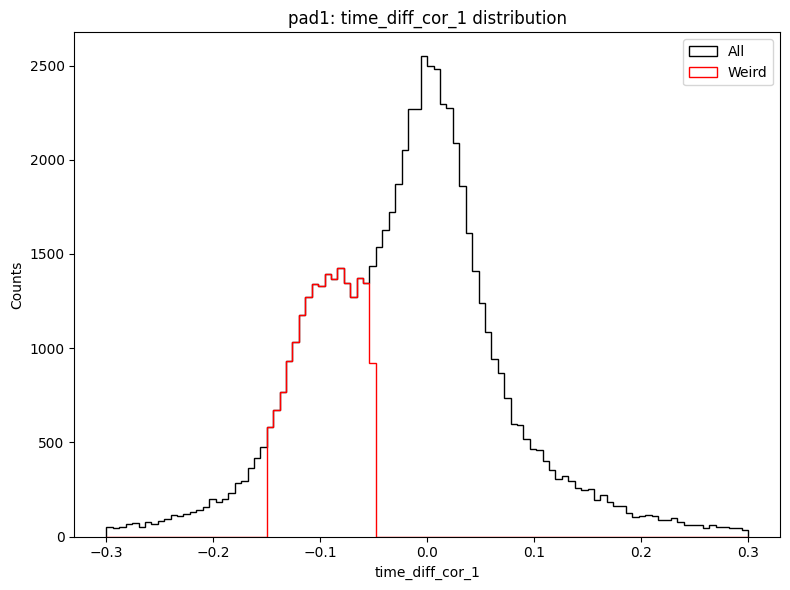

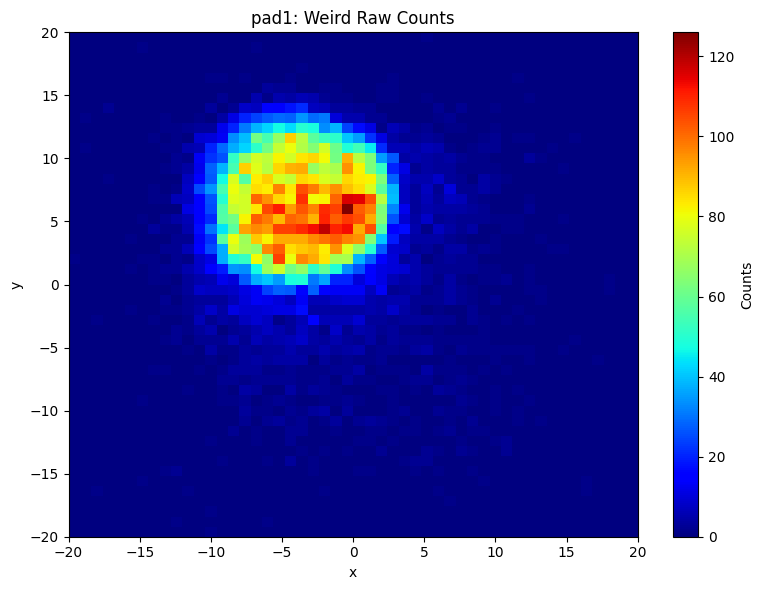

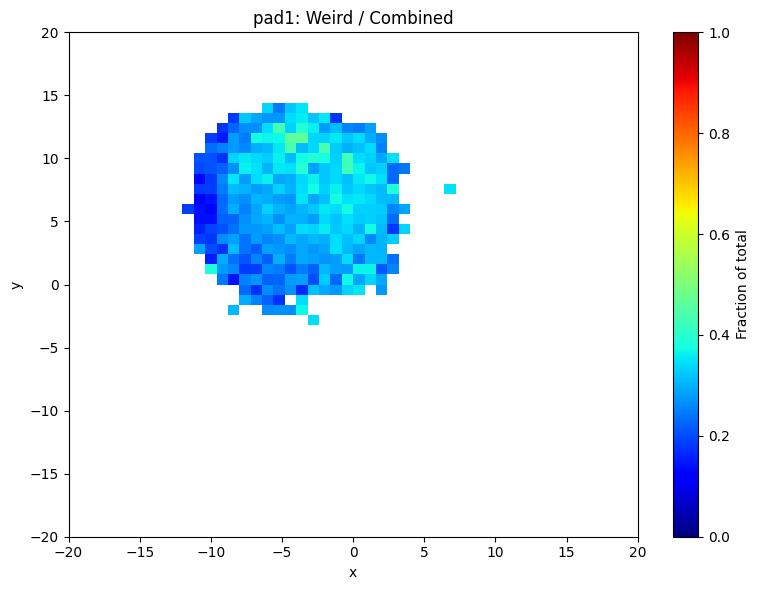

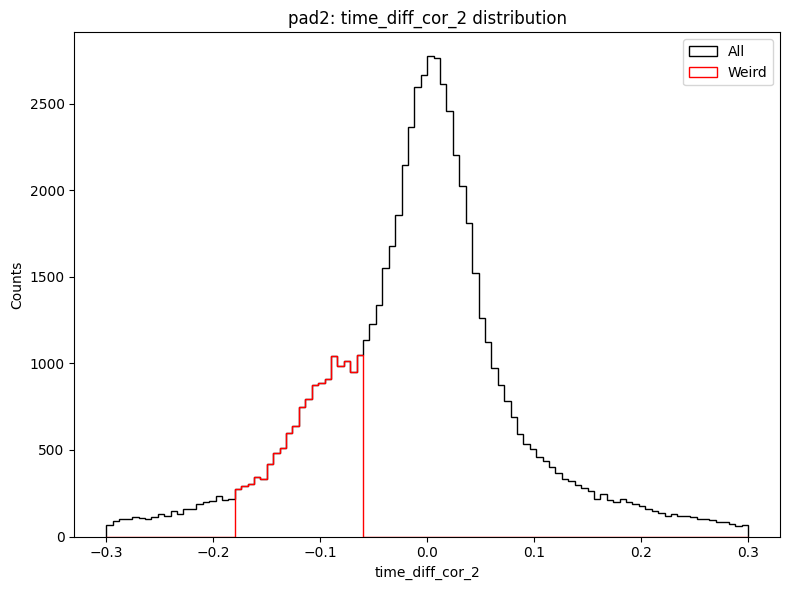

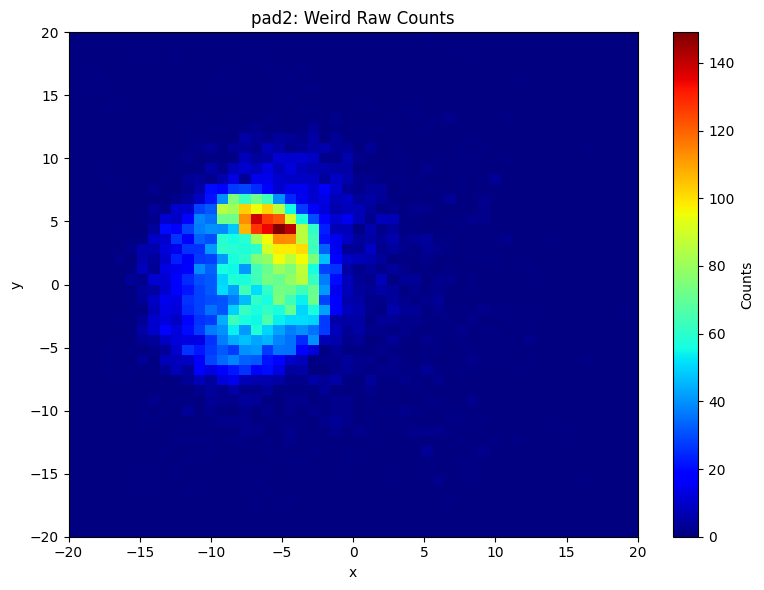

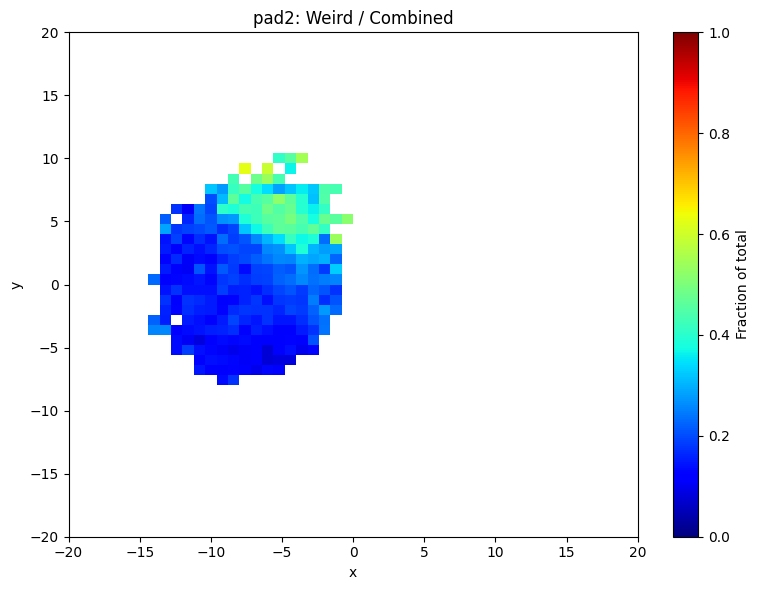

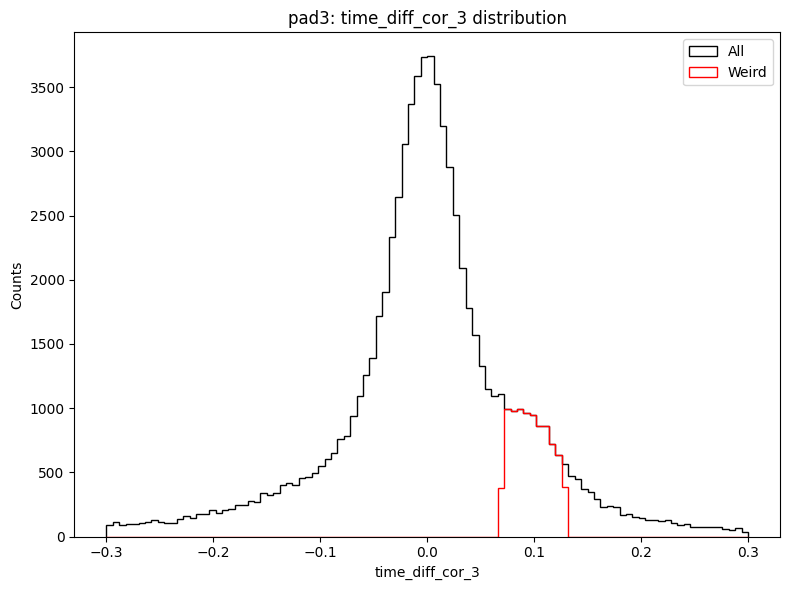

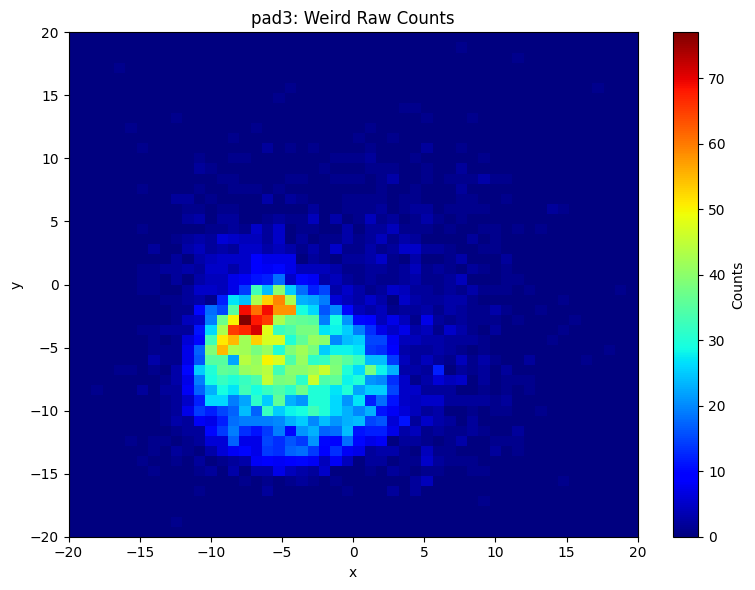

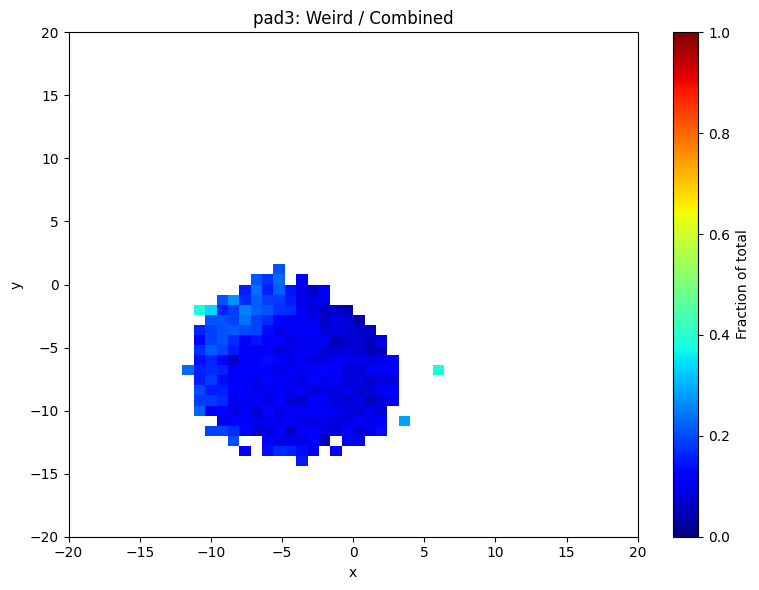

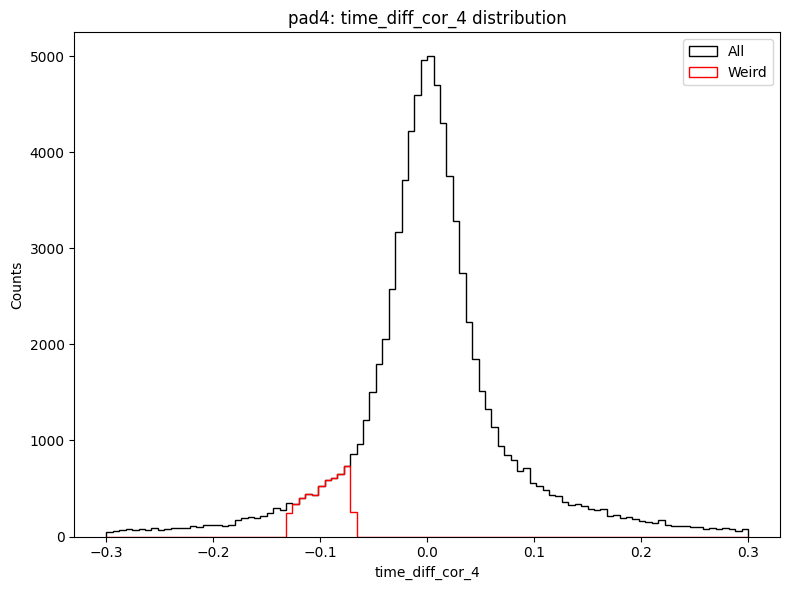

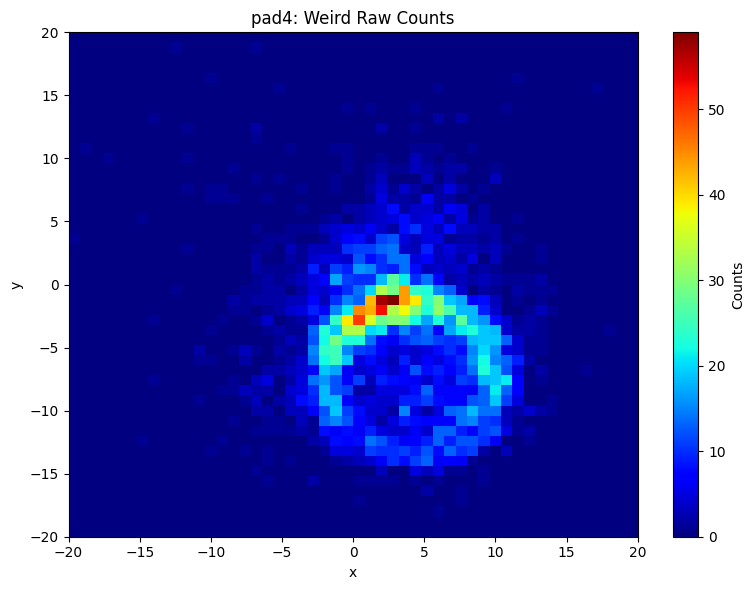

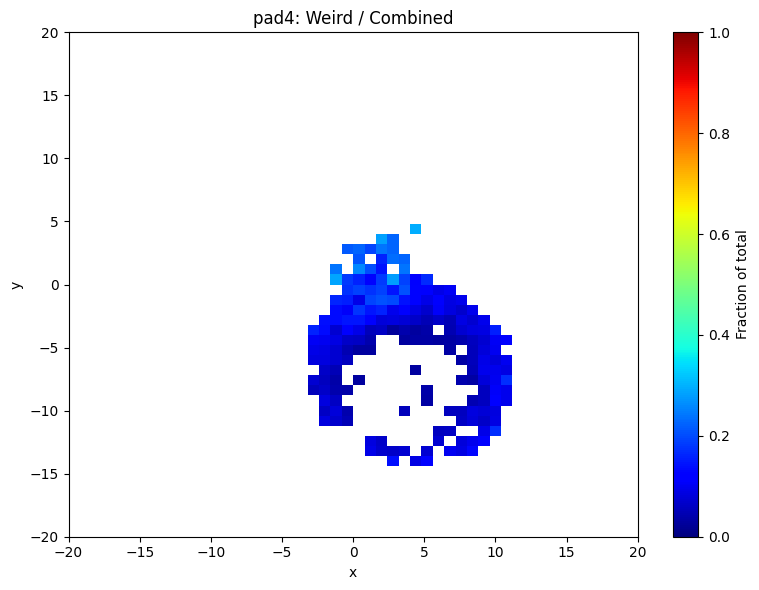

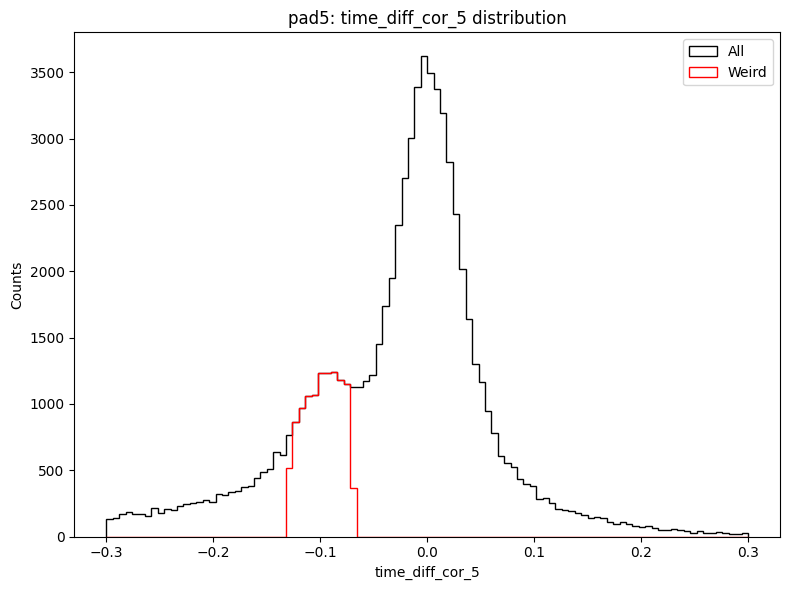

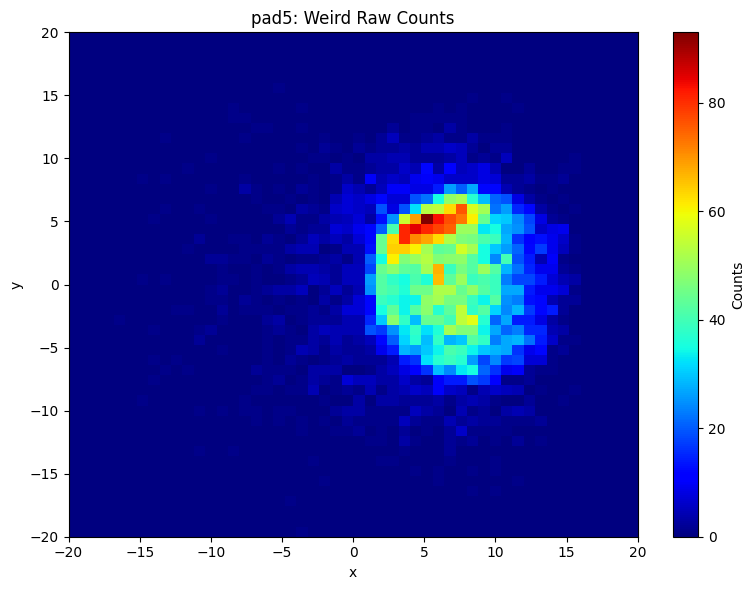

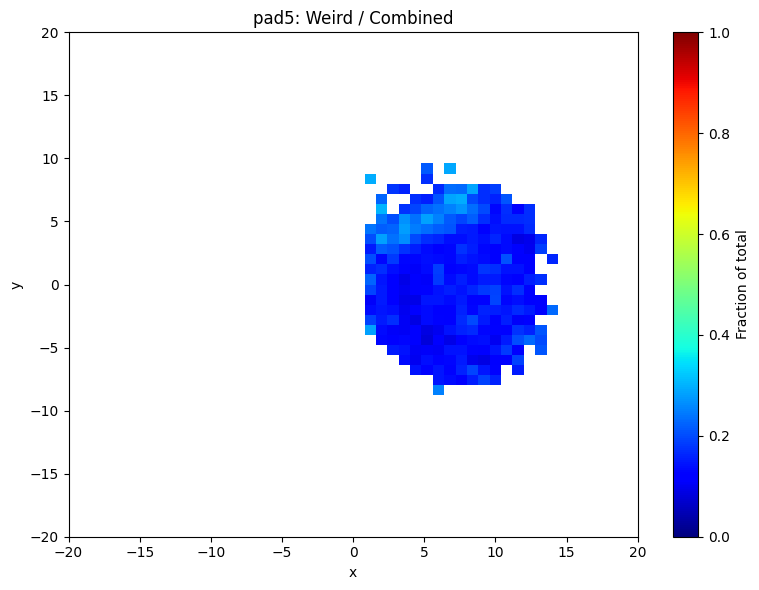

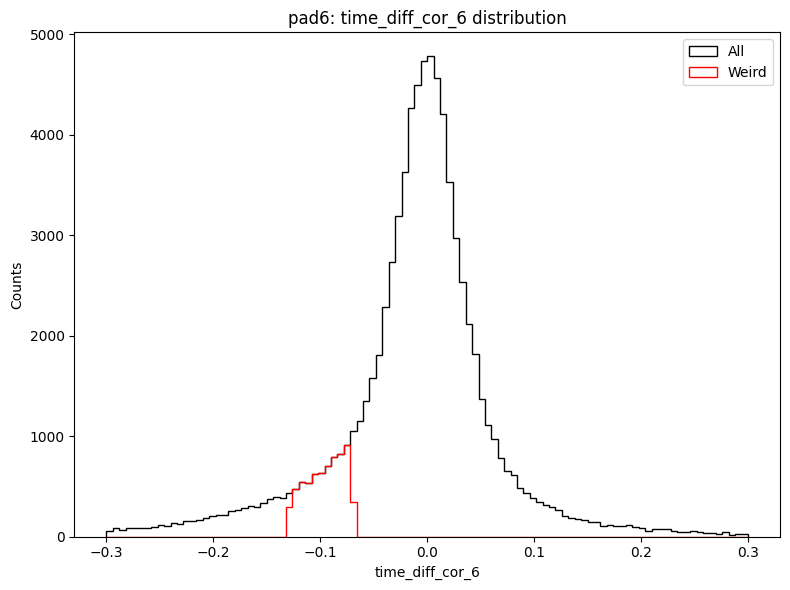

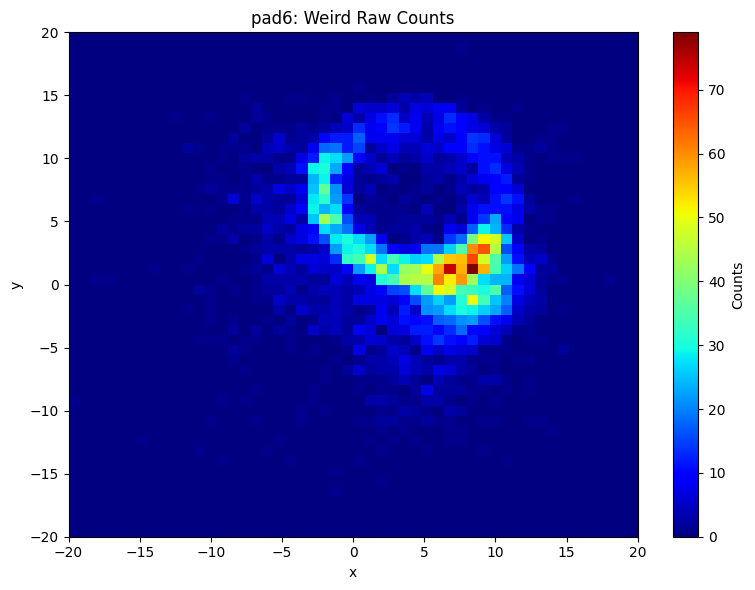

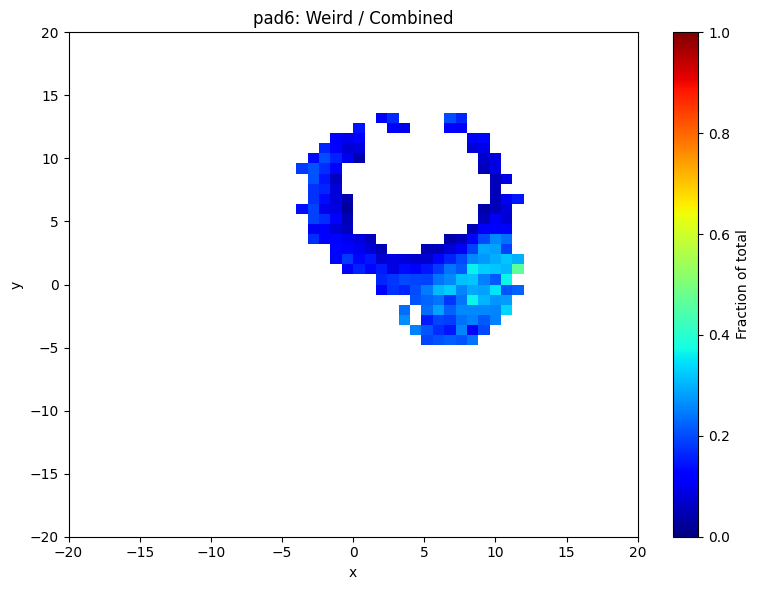

In [31]:
weird_bounds = {
    'pad0': {'var': 'time_diff_cor_0', 'lower': -0.13, 'upper': -0.07},
    'pad1': {'var': 'time_diff_cor_1', 'lower': -0.15, 'upper': -0.05},
    'pad2': {'var': 'time_diff_cor_2', 'lower': -0.18, 'upper': -0.06},
    'pad3': {'var': 'time_diff_cor_3', 'lower': +0.07, 'upper': +0.13},
    'pad4': {'var': 'time_diff_cor_4', 'lower': -0.13, 'upper': -0.07},
    'pad5': {'var': 'time_diff_cor_5', 'lower': -0.13, 'upper': -0.07},
    'pad6': {'var': 'time_diff_cor_6', 'lower': -0.13, 'upper': -0.07},
}

# 2. General settings
bins_2d = 50
range_2d = [[-20, 20], [-20, 20]]
bins_1d = 100
range_1d = (-0.3, 0.3)  # Adjust based on your data
weird_min_threshold = 10

# 3. Compute combined 2D histogram once
hist_combined, xedges, yedges = np.histogram2d(
    df_combined['hitX'], df_combined['hitY'],
    bins=bins_2d, range=range_2d
)

# 4. Loop over pads
for pad_name, bounds in weird_bounds.items():
    var = bounds['var']
    lower = bounds['lower']
    upper = bounds['upper']

    # Build weird subset
    df_weird = df_combined[(df_combined[var] > lower) & (df_combined[var] < upper)]
    df_all = df_combined[(df_combined[var] > -0.3) & (df_combined[var] < 0.3)]

    # ----- Plot 1D distribution overlay -----
    fig, ax = plt.subplots(figsize=(8, 6))
    # Normal
    ax.hist(df_combined[var], bins=bins_1d, range=range_1d, histtype='step', label='All', color='black')
    # Weird
    ax.hist(df_weird[var], bins=bins_1d, range=range_1d, histtype='step', label='Weird', color='red')

    ax.set_xlabel(var)
    ax.set_ylabel('Counts')
    ax.set_title(f'{pad_name}: {var} distribution')
    ax.legend()
    plt.tight_layout()

    # Compute 2D histogram for weird
    hist_weird, _, _ = np.histogram2d(
        df_weird['hitX'], df_weird['hitY'],
        bins=bins_2d, range=range_2d
    )

    # Compute 2D histogram for all
    hist_all, _, _ = np.histogram2d(
        df_all['hitX'], df_all['hitY'],
        bins=bins_2d, range=range_2d
    )

    # Compute fraction
    with np.errstate(divide='ignore', invalid='ignore'):
        weird_fraction = np.divide(hist_weird, hist_all, where=hist_all > 0)
    mask = (hist_all == 0) | (hist_weird < weird_min_threshold)
    weird_fraction = np.ma.masked_where(mask, weird_fraction)

    # ----- Plot 2D raw counts -----
    fig, ax = plt.subplots(figsize=(8, 6))
    pcm = ax.pcolormesh(xedges, yedges, hist_weird.T, cmap='jet')
    fig.colorbar(pcm, ax=ax, label='Counts')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{pad_name}: Weird Raw Counts')
    plt.tight_layout()

    # ----- Plot 2D normalized fraction -----
    fig, ax = plt.subplots(figsize=(8, 6))
    pcm = ax.pcolormesh(xedges, yedges, weird_fraction.T, cmap='jet', vmin=0, vmax=1)
    fig.colorbar(pcm, ax=ax, label='Fraction of total')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{pad_name}: Weird / Combined')
    plt.tight_layout()

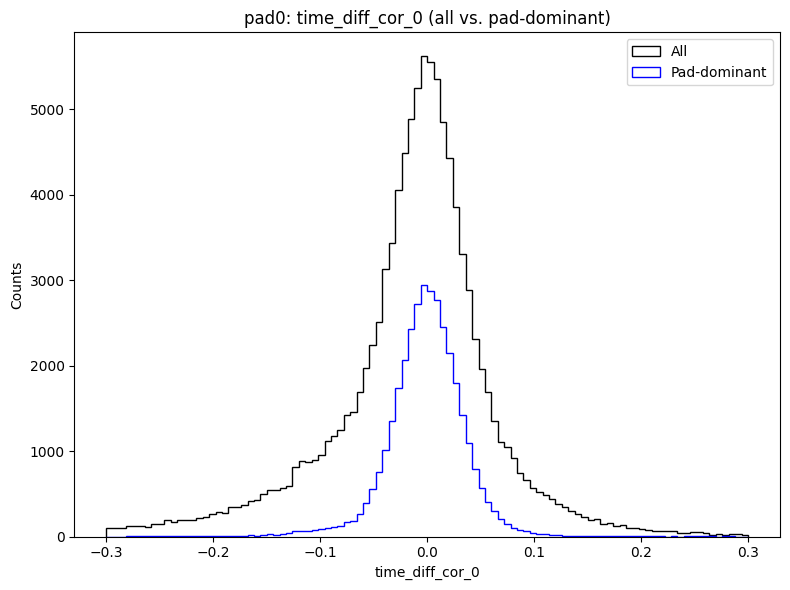

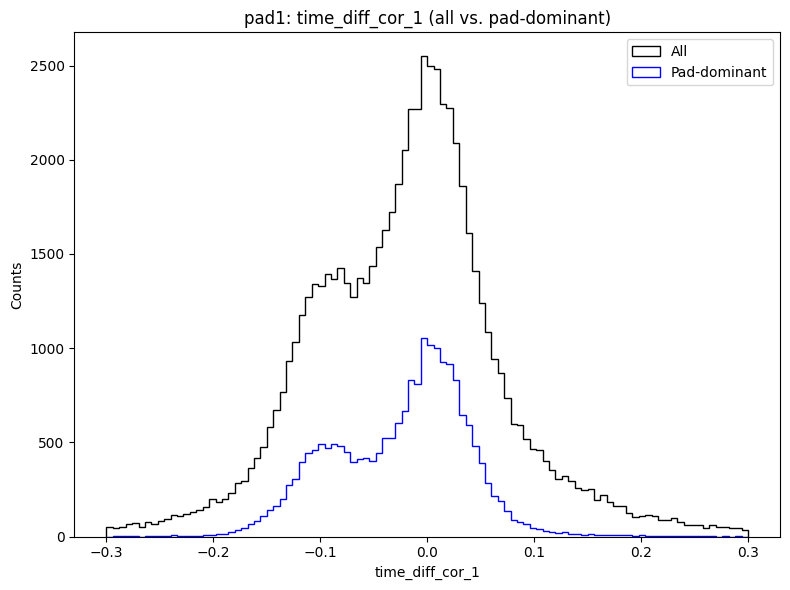

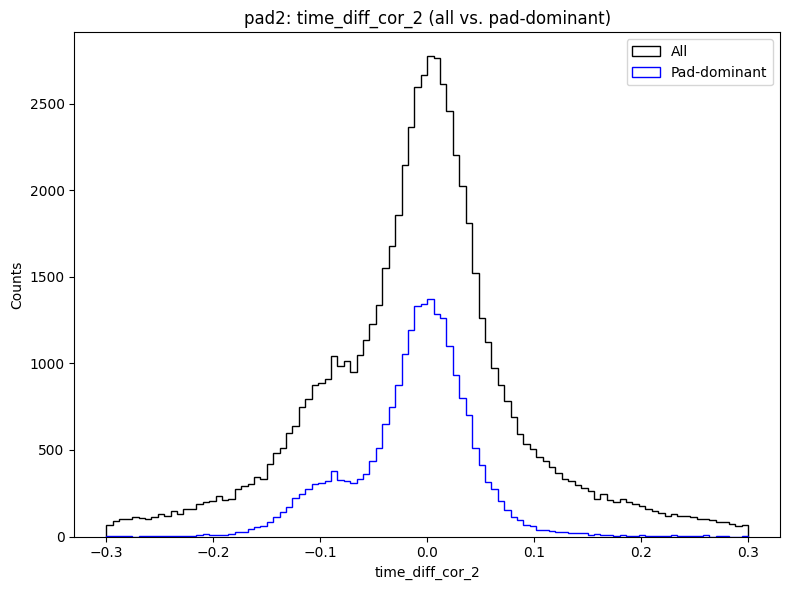

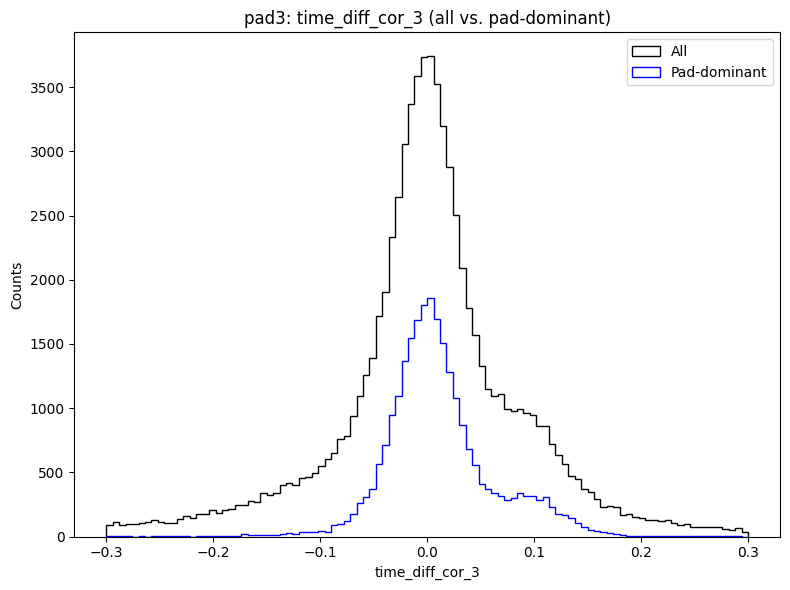

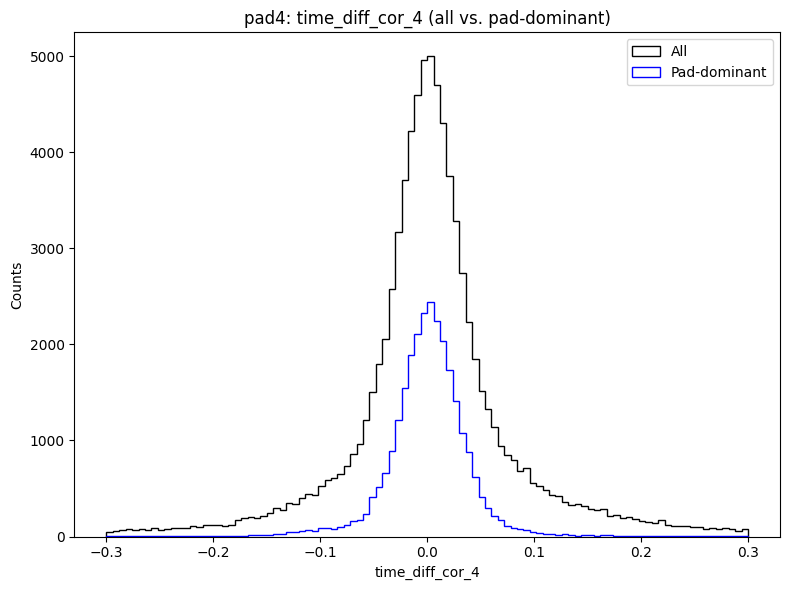

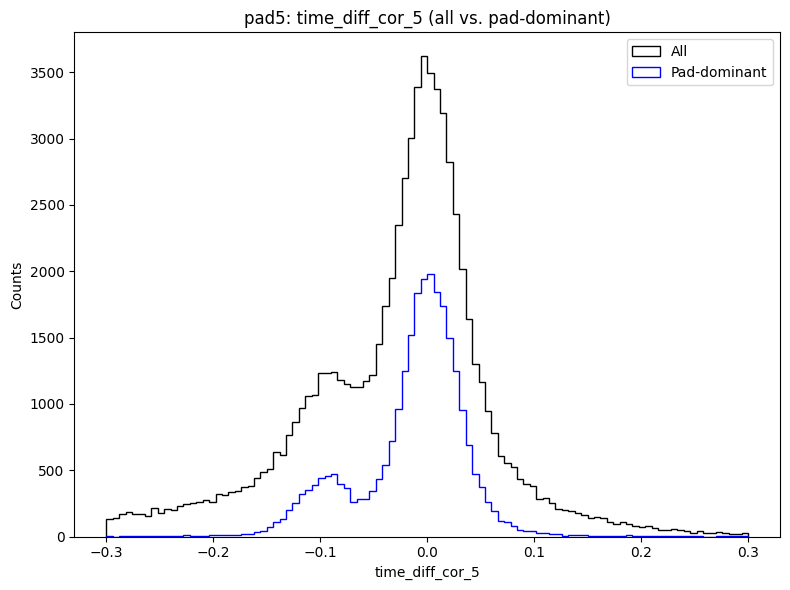

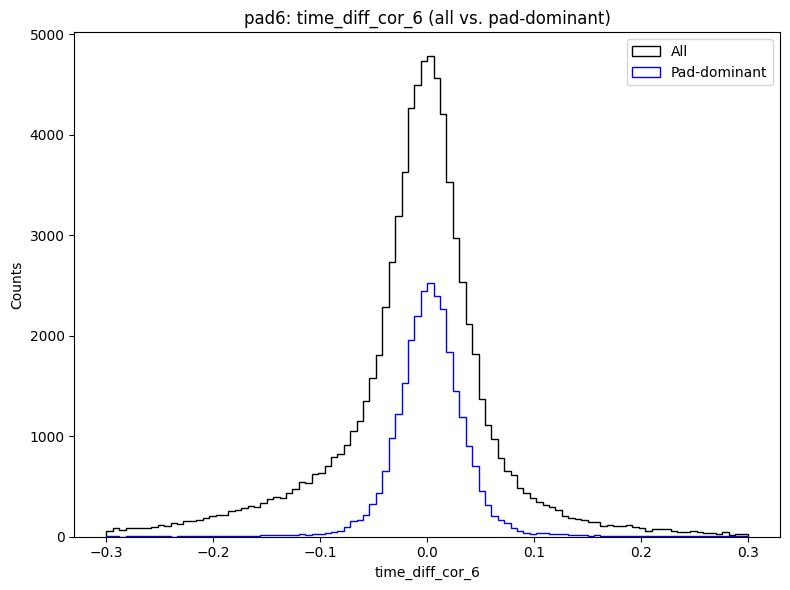

In [33]:
# 1. Define settings
bins_1d = 100
range_1d = (-0.3, 0.3)  # Adjust as needed

# 2. Loop over pads
for pad_name, bounds in weird_bounds.items():
    var = bounds['var']
    pad_index = int(pad_name.replace('pad', ''))  # Extract 0,1,...6 from 'padX'

    # Build list of all totcharge column names
    totcharge_columns = [f'totcharge_{i}' for i in range(7)]

    # Find rows where this pad has the largest totcharge
    condition = (
        (df_combined[f'totcharge_{pad_index}'] > df_combined[[col for col in totcharge_columns if col != f'totcharge_{pad_index}']].max(axis=1))
    )
    df_pad_dominant = df_combined[condition]

    # ----- Plot 1D distribution overlay -----
    fig, ax = plt.subplots(figsize=(8, 6))
    # Full dataset
    ax.hist(df_combined[var], bins=bins_1d, range=range_1d, histtype='step', label='All', color='black')
    # Subset: pad-dominant
    ax.hist(df_pad_dominant[var], bins=bins_1d, range=range_1d, histtype='step', label='Pad-dominant', color='blue')

    ax.set_xlabel(var)
    ax.set_ylabel('Counts')
    ax.set_title(f'{pad_name}: {var} (all vs. pad-dominant)')
    ax.legend()
    plt.tight_layout()

In [16]:
run_number = 325
pool_number = 5
# run_path = f'/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run{run_number}-Pool{pool_number}_treeParam.root'
# run_path = f'/data/akallits/Saclay_Analysis/data/data/2023_April_h4/processedTrees/ParameterTrees/Run{run_number}-Pool{pool_number}_treeParam.root'
run_path = f'/local/home/dn277127/Bureau/picosec/Run{run_number}-Pool{pool_number}_treeParam.root'
# run_path = f'/home/dylan/Desktop/picosec/Run{run_number}-Pool{pool_number}_treeParam.root'